**Lab2-DL: C4a-cnn-konklusjon-losninger.ipynb** (ELMED219) | Løsningsforslag

_Løsninger til oppgavene i C4-cnn-konklusjon.ipynb_

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab2-DL/notebooks/C4a-cnn-konklusjon-losninger.ipynb)

# 📝 Løsningsforslag: CNN Konklusjon

Denne notebooken inneholder løsningsforslag til de fire oppgavene i C4-cnn-konklusjon.ipynb.

---

## Innholdsfortegnelse

| Oppgave | Type | Innhold |
|---------|------|--------|
| **1** | Kode | Modell-sammenligning (CNN vs pretrent) |
| **2** | Kode | Medisinsk datasett (MedMNIST) |
| **3** | Drøfting | Etiske betraktninger |
| **4** | Drøfting | Veien videre |

---

# 📝 Oppgave 1: Modell-sammenligning

## Oppgaveformulering

> **Sammenlign vår CNN-modell med en pretrent modell (ResNet, VGG, etc.) på samme datasett.**
>
> Spørsmål å reflektere over:
> - Hvilken modell presterer best?
> - Hvorfor er pretrente modeller ofte bedre?
> - Når er det lurt å bygge fra bunnen av?

---

## 1.1 Introduksjon og motivasjon

### Hvorfor sammenligne med pretrente modeller?

I moderne dyp læring står vi ofte overfor et fundamentalt valg når vi skal løse et klassifikasjonsproblem:

**Skal vi trene et nettverk fra bunnen av, eller bruke et allerede trent nettverk som utgangspunkt?**

Dette spørsmålet er spesielt relevant i medisinsk AI, der vi ofte har:
- **Begrenset datamengde** (personvern, sjeldne tilstander)
- **Høye krav til ytelse** (diagnostiske konsekvenser)
- **Behov for rask utvikling** (klinisk implementering)

### Sentrale begreper

#### Transfer Learning (Overføringslæring)

> **Transfer learning** er en maskinlæringsteknikk der en modell trent på én oppgave 
> (kilde-domene) brukes som utgangspunkt for en annen oppgave (mål-domene).

**Analogi**: Tenk på en radiolog som har lært å tolke CT-bilder. Denne kunnskapen 
(kantdeteksjon, anatomi, kontrast) er delvis overførbar til MR-tolkning, selv om 
modalitetene er forskjellige.

```
┌─────────────────┐         ┌─────────────────┐
│  ImageNet       │         │  Medisinsk      │
│  (14M bilder)   │  ──→    │  Klassifikasjon │
│                 │         │  (1000 bilder)  │
└─────────────────┘         └─────────────────┘
   Kilde-domene               Mål-domene
```

#### Fine-tuning (Finjustering)

> **Fine-tuning** er prosessen med å tilpasse en pretrent modell til et nytt 
> datasett ved å fortsette treningen, enten på hele modellen eller deler av den.

**Strategier for fine-tuning:**

| Strategi | Beskrivelse | Når bruke |
|----------|-------------|----------|
| **Feature extraction** | Frys alle lag unntatt siste | Lite data, lignende domene |
| **Delvis fine-tuning** | Frys tidlige lag, tren sene | Middels data |
| **Full fine-tuning** | Tren alle lag | Mye data, ulikt domene |

### Utfordringer i denne oppgaven

1. **Domeneskift**: ImageNet inneholder naturlige bilder (hunder, biler), mens vi har blomster
2. **Modellstørrelse**: ResNet18 har 11M parametre vs vår enkle CNN
3. **Beregningskostnader**: Større modeller krever mer GPU-minne
4. **Overfitting-risiko**: Mange parametre + lite data = risiko for overtilpasning

## 1.2 Løsning: Implementasjon

### Steg 1: Importer og miljøoppsett

Vi starter med å importere nødvendige biblioteker og sjekke hvilken enhet (CPU/GPU/MPS) som er tilgjengelig.

In [50]:
# ============================================================================
# OPPGAVE 1: MODELL-SAMMENLIGNING
# ============================================================================
# 
# Formål: Sammenligne egenbygd CNN med pretrent ResNet18 på blomsterdatasettet
#
# Hypotese: ResNet18 med transfer learning vil prestere bedre fordi:
#   1. Den har lært generelle visuelle features fra ImageNet
#   2. Disse features (kanter, teksturer, former) er overførbare
#   3. Vi trenger bare å finjustere det siste laget
#
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import time

# ─────────────────────────────────────────────────────────────────────────────
# ENHETSDETEKSJON
# ─────────────────────────────────────────────────────────────────────────────
# PyTorch støtter flere akseleratorer:
#   - CUDA: NVIDIA GPUer (raskest for dyp læring)
#   - MPS: Apple Silicon (M1/M2/M3/M4) Metal Performance Shaders
#   - CPU: Standard, men tregere

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"🚀 GPU tilgjengelig: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
    print("🍎 Apple Silicon MPS tilgjengelig")
else:
    device = torch.device('cpu')
    print("💻 Kjører på CPU (kan være tregt)")

print(f"\n📊 PyTorch versjon: {torch.__version__}")

🍎 Apple Silicon MPS tilgjengelig

📊 PyTorch versjon: 2.6.0


### Steg 2: Definer egenbygd CNN

Først definerer vi vår egen CNN-arkitektur – et relativt enkelt nettverk bygget fra bunnen av.

**Arkitektur:**
```
Input (224×224×3)
    │
    ▼
┌─────────────────┐
│ Conv2d 3→32     │  Konvolusjon: Lær 32 filtre (3×3)
│ ReLU + MaxPool  │  Aktivering + Downsampling
└─────────────────┘
    │ 112×112×32
    ▼
┌─────────────────┐
│ Conv2d 32→64    │  Konvolusjon: Lær 64 filtre
│ ReLU + MaxPool  │
└─────────────────┘
    │ 56×56×64
    ▼
┌─────────────────┐
│ Conv2d 64→128   │  Konvolusjon: Lær 128 filtre
│ ReLU + MaxPool  │
└─────────────────┘
    │ 28×28×128
    ▼
┌─────────────────┐
│ Flatten         │  Gjør om til 1D-vektor
│ Dropout(0.5)    │  Regularisering
│ FC 100352→256   │  Fullt tilkoblet lag
│ Dropout(0.5)    │
│ FC 256→5        │  Output: 5 klasser
└─────────────────┘
    │
    ▼
Output (5 klasser)
```

In [51]:
# ============================================================================
# EGENBYGD CNN - Bygget fra bunnen av
# ============================================================================
#
# Denne modellen har INGEN forhåndskunnskaper - alle vekter initialiseres
# tilfeldig og må læres fra vårt lille datasett.
#
# Arkitektur-valg:
#   - 3 konvolusjonelle lag: Hierarkisk feature-ekstraksjon
#   - MaxPooling: Reduserer romlig dimensjon, gir translasjonsinvarians
#   - Dropout: Regularisering for å forhindre overfitting
#   - 2 fullt tilkoblede lag: Klassifikasjons-hode
#
# ============================================================================

class EgenbygdCNN(nn.Module):
    """
    Enkel CNN-arkitektur bygget fra bunnen av.
    
    Denne modellen illustrerer hvordan et CNN fungerer, men har
    begrensninger sammenlignet med pretrente modeller:
    - Færre lag = mindre kapasitet for komplekse mønstre
    - Tilfeldig initialisering = trenger mer data for å lære
    - Ingen forhåndskunnskap = må lære alt fra scratch
    """
    
    def __init__(self, num_classes=5):
        super().__init__()
        
        # ─────────────────────────────────────────────────────────────────────
        # FEATURE EXTRACTION (Konvolusjonelle lag)
        # ─────────────────────────────────────────────────────────────────────
        # Disse lagene lærer å gjenkjenne visuelle mønstre:
        #   - Lag 1: Enkle features (kanter, fargegradienter)
        #   - Lag 2: Kombinasjoner (hjørner, teksturer)
        #   - Lag 3: Komplekse mønstre (deler av objekter)
        
        self.features = nn.Sequential(
            # Lag 1: Input 224×224×3 → Output 112×112×32
            nn.Conv2d(in_channels=3,      # RGB-bilde har 3 kanaler
                      out_channels=32,    # Lær 32 ulike filtre
                      kernel_size=3,      # 3×3 konvolusjonskjerne
                      padding=1),         # Behold romlig dimensjon
            nn.ReLU(inplace=True),        # Ikke-lineær aktivering
            nn.MaxPool2d(kernel_size=2,   # Halver dimensjonene
                         stride=2),
            
            # Lag 2: 112×112×32 → 56×56×64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Lag 3: 56×56×64 → 28×28×128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # ─────────────────────────────────────────────────────────────────────
        # CLASSIFIER (Klassifiserings-hode)
        # ─────────────────────────────────────────────────────────────────────
        # Tar feature-vektoren og mapper til klasse-sannsynligheter
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),              # 50% dropout for regularisering
            nn.Linear(128 * 28 * 28,      # Input: 100,352 features
                      256),               # Output: 256 nevroner
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)   # Output: 5 klasser
        )
    
    def forward(self, x):
        """Forward pass gjennom nettverket."""
        x = self.features(x)              # Ekstraher features
        x = x.view(x.size(0), -1)         # Flatten: [B, 128, 28, 28] → [B, 100352]
        x = self.classifier(x)            # Klassifiser
        return x

# ─────────────────────────────────────────────────────────────────────────────
# INSTANSIER OG ANALYSER MODELLEN
# ─────────────────────────────────────────────────────────────────────────────

egen_modell = EgenbygdCNN(num_classes=5)
egen_params = sum(p.numel() for p in egen_modell.parameters())

print("📊 EGENBYGD CNN - Modellanalyse")
print("=" * 50)
print(f"Totalt parametre: {egen_params:,}")
print(f"\nLag-detaljer:")
for name, param in egen_modell.named_parameters():
    print(f"  {name:30} {param.numel():>10,} parametre")

📊 EGENBYGD CNN - Modellanalyse
Totalt parametre: 25,784,901

Lag-detaljer:
  features.0.weight                     864 parametre
  features.0.bias                        32 parametre
  features.3.weight                  18,432 parametre
  features.3.bias                        64 parametre
  features.6.weight                  73,728 parametre
  features.6.bias                       128 parametre
  classifier.1.weight            25,690,112 parametre
  classifier.1.bias                     256 parametre
  classifier.4.weight                 1,280 parametre
  classifier.4.bias                       5 parametre


### Steg 3: Definer pretrent ResNet18 med Transfer Learning

Nå lager vi en ResNet18-modell som bruker **transfer learning**:

**ResNet18-arkitektur (forenklet):**
```
Input (224×224×3)
    │
    ▼
┌─────────────────────────────────────────────┐
│           PRETRENT PÅ IMAGENET             │ ← FRYSES
│  (11 millioner parametre, 1000 klasser)    │
│                                             │
│  Conv1 → BN → ReLU → MaxPool               │
│  Layer1 (2 ResBlock)                       │
│  Layer2 (2 ResBlock)                       │
│  Layer3 (2 ResBlock)                       │
│  Layer4 (2 ResBlock)                       │
│  AdaptiveAvgPool → 512 features            │
└─────────────────────────────────────────────┘
    │ 512 features
    ▼
┌─────────────────────────────────────────────┐
│          NYTT KLASSIFIKASJONSHODE          │ ← TRENES
│  Dropout(0.5) → Linear(512→5)              │
└─────────────────────────────────────────────┘
    │
    ▼
Output (5 klasser)
```

#### Hva betyr "frysing" av lag?

> Når vi **fryser** (freeze) et lag, setter vi `requires_grad=False` på parametrene.
> Dette betyr at vektene IKKE oppdateres under trening - de beholdes slik de var
> etter ImageNet-trening.

**Fordeler med frysing:**
- Raskere trening (færre gradientberegninger)
- Mindre overfitting (færre trenbare parametre)
- Bevarer lærte features

**Ulemper med frysing:**
- Kan ikke tilpasse lavnivå-features til nytt domene
- Suboptimalt hvis domenet er svært forskjellig

In [52]:
# ============================================================================
# RESNET18 MED TRANSFER LEARNING
# ============================================================================
#
# ResNet18 er pretrent på ImageNet - et datasett med:
#   - 14 millioner bilder
#   - 1000 klasser (dyr, kjøretøy, objekter, etc.)
#   - State-of-the-art treningsprosedyre
#
# Ved å bruke transfer learning får vi:
#   - Ferdig lærte lavnivå-features (kanter, teksturer)
#   - Ferdig lærte mellomnivå-features (former, mønstre)
#   - Vi trenger bare å lære høynivå-kombinasjoner for våre klasser
#
# ============================================================================

def lag_resnet18_transfer(num_classes=5, frys_features=True):
    """
    Lager ResNet18 med transfer learning.
    
    Parametere:
    -----------
    num_classes : int
        Antall output-klasser (5 for blomster)
    frys_features : bool
        Hvis True: Frys alle lag unntatt siste (feature extraction)
        Hvis False: Tren alle lag (full fine-tuning)
    
    Returnerer:
    -----------
    modell : nn.Module
        ResNet18 tilpasset vårt problem
    """
    
    # ─────────────────────────────────────────────────────────────────────────
    # LAST PRETRENT MODELL
    # ─────────────────────────────────────────────────────────────────────────
    # weights=ResNet18_Weights.IMAGENET1K_V1 gir beste pretrente vekter
    
    modell = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # ─────────────────────────────────────────────────────────────────────────
    # FRYS FEATURE-LAG (valgfritt)
    # ─────────────────────────────────────────────────────────────────────────
    # Ved å sette requires_grad=False stopper vi gradientberegning
    # og vektoppdatering for disse parametrene.
    #
    # Dette er "feature extraction"-tilnærmingen:
    # - Pretrente lag fungerer som en fast feature-ekstraktor
    # - Kun det siste laget tilpasses vårt datasett
    
    if frys_features:
        print("🔒 Fryser feature-lag (transfer learning mode)")
        for param in modell.parameters():
            param.requires_grad = False
    else:
        print("🔓 Alle lag trenbare (full fine-tuning mode)")
    
    # ─────────────────────────────────────────────────────────────────────────
    # ERSTATT KLASSIFIKASJONSHODE
    # ─────────────────────────────────────────────────────────────────────────
    # Originalt hode: Linear(512 → 1000) for ImageNet
    # Nytt hode: Dropout + Linear(512 → 5) for blomster
    #
    # Merk: Nye lag har requires_grad=True som default
    
    num_features = modell.fc.in_features  # 512 for ResNet18
    
    modell.fc = nn.Sequential(
        nn.Dropout(0.5),                   # Regularisering
        nn.Linear(num_features, num_classes)  # 512 → 5
    )
    
    return modell

# ─────────────────────────────────────────────────────────────────────────────
# INSTANSIER OG ANALYSER MODELLEN
# ─────────────────────────────────────────────────────────────────────────────

resnet_modell = lag_resnet18_transfer(num_classes=5, frys_features=True)

# Tell parametre
resnet_total = sum(p.numel() for p in resnet_modell.parameters())
resnet_trainable = sum(p.numel() for p in resnet_modell.parameters() if p.requires_grad)
resnet_frozen = resnet_total - resnet_trainable

print("\n📊 RESNET18 - Modellanalyse")
print("=" * 50)
print(f"Totalt parametre:    {resnet_total:>12,}")
print(f"Frosne parametre:    {resnet_frozen:>12,} (fra ImageNet)")
print(f"Trenbare parametre:  {resnet_trainable:>12,} (nytt hode)")
print(f"\nReduksjon i trenbare parametre: {100*(1 - resnet_trainable/resnet_total):.1f}%")

🔒 Fryser feature-lag (transfer learning mode)

📊 RESNET18 - Modellanalyse
Totalt parametre:      11,179,077
Frosne parametre:      11,176,512 (fra ImageNet)
Trenbare parametre:         2,565 (nytt hode)

Reduksjon i trenbare parametre: 100.0%


### Steg 4: Visualiser og sammenlign modellarkitekturer

La oss lage en visuell sammenligning av de to modellene.

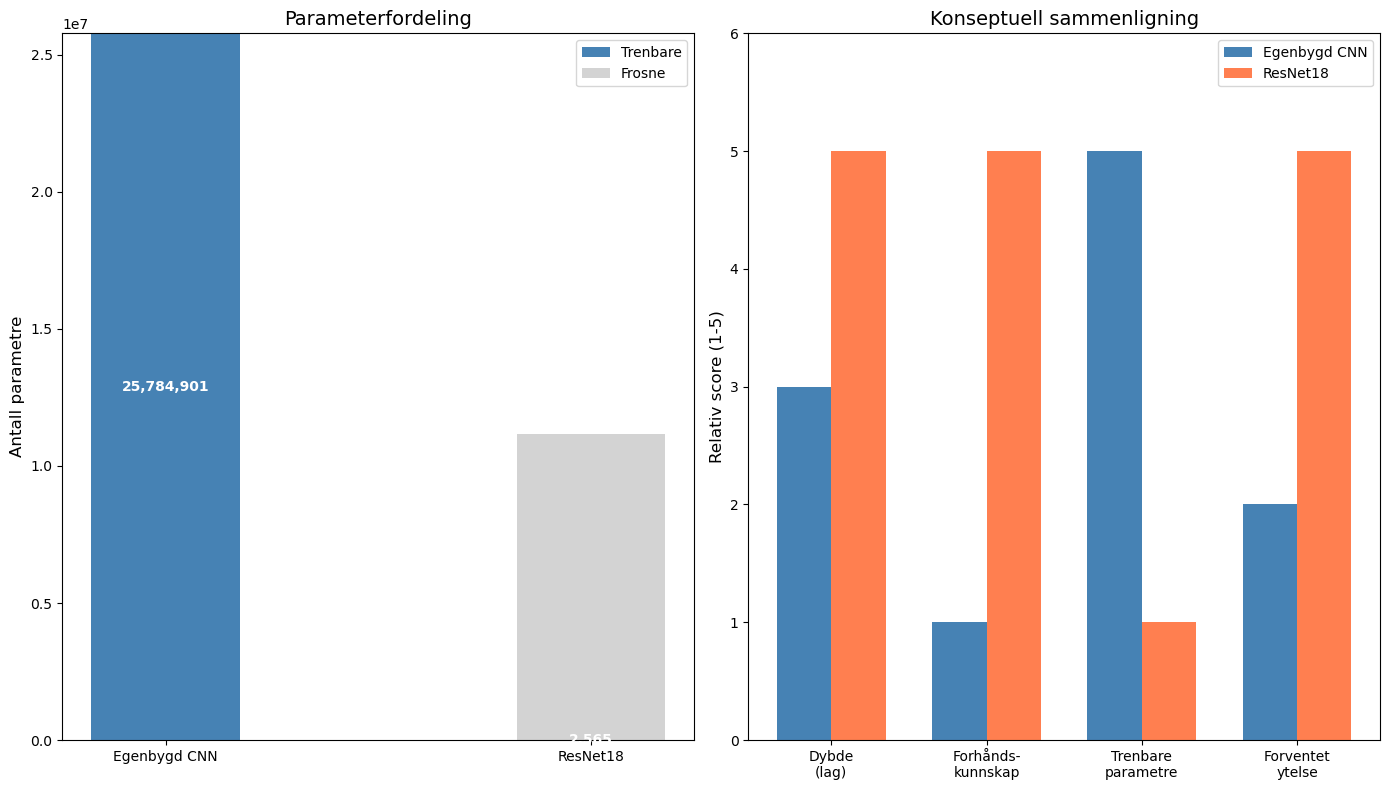


💡 Tolkning:
   - Egenbygd CNN: Mange trenbare parametre, men ingen forhåndskunnskap
   - ResNet18: Dyp arkitektur med ImageNet-kunnskap, få trenbare parametre


In [53]:
# ============================================================================
# VISUALISER MODELLARKITEKTURER
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# ─────────────────────────────────────────────────────────────────────────────
# VENSTRE: Parameter-sammenligning
# ─────────────────────────────────────────────────────────────────────────────

modeller = ['Egenbygd CNN', 'ResNet18']
trainable = [egen_params, resnet_trainable]
frozen = [0, resnet_frozen]

x = np.arange(len(modeller))
width = 0.35

bars1 = axes[0].bar(x, trainable, width, label='Trenbare', color='steelblue')
bars2 = axes[0].bar(x, frozen, width, bottom=trainable, label='Frosne', color='lightgray')

axes[0].set_ylabel('Antall parametre', fontsize=12)
axes[0].set_title('Parameterfordeling', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(modeller)
axes[0].legend()

# Legg til tall på søylene
for bar, val in zip(bars1, trainable):
    axes[0].text(bar.get_x() + bar.get_width()/2, val/2, 
                 f'{val:,}', ha='center', va='center', fontweight='bold', color='white')

# ─────────────────────────────────────────────────────────────────────────────
# HØYRE: Konseptuell sammenligning
# ─────────────────────────────────────────────────────────────────────────────

kategorier = ['Dybde\n(lag)', 'Forhånds-\nkunnskap', 'Trenbare\nparametre', 'Forventet\nytelse']
egen_scores = [3, 1, 5, 2]  # Relativ skala 1-5
resnet_scores = [5, 5, 1, 5]

x = np.arange(len(kategorier))
width = 0.35

axes[1].bar(x - width/2, egen_scores, width, label='Egenbygd CNN', color='steelblue')
axes[1].bar(x + width/2, resnet_scores, width, label='ResNet18', color='coral')

axes[1].set_ylabel('Relativ score (1-5)', fontsize=12)
axes[1].set_title('Konseptuell sammenligning', fontsize=14)
axes[1].set_xticks(x)
axes[1].set_xticklabels(kategorier)
axes[1].legend()
axes[1].set_ylim(0, 6)

plt.tight_layout()
plt.savefig('./ressurser/modell_sammenligning_arkitektur.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 Tolkning:")
print("   - Egenbygd CNN: Mange trenbare parametre, men ingen forhåndskunnskap")
print("   - ResNet18: Dyp arkitektur med ImageNet-kunnskap, få trenbare parametre")

### Steg 5: Klargjør datasett

Vi bruker ImageNet-normalisering for begge modellene, siden ResNet forventer dette.

In [54]:
# ============================================================================
# DATAKLARGJØRING
# ============================================================================
#
# Viktige valg:
#   1. Bildestørrelse: 224×224 (standard for ImageNet-modeller)
#   2. Normalisering: ImageNet-statistikk (mean, std)
#   3. Augmentering: Øker effektivt datasettstørrelsen
#
# ============================================================================

# ─────────────────────────────────────────────────────────────────────────────
# TRANSFORMASJONER
# ─────────────────────────────────────────────────────────────────────────────
# Treningsdata: Med augmentering for å øke variasjon
# Valideringsdata: Uten augmentering for rettferdig evaluering

# ImageNet-statistikk (brukes for pretrente modeller)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),           # Standardstørrelse
    transforms.RandomHorizontalFlip(p=0.5),  # 50% sjanse for speiling
    transforms.RandomRotation(15),           # ±15° rotasjon
    transforms.ColorJitter(brightness=0.2,   # Lysstyrke-variasjon
                           contrast=0.2),
    transforms.ToTensor(),                   # Konverter til tensor
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)  # Normaliser
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# ─────────────────────────────────────────────────────────────────────────────
# LAST DATA
# ─────────────────────────────────────────────────────────────────────────────

data_dir = Path('../data/flowers')

if data_dir.exists():
    # Last fullt datasett med trenings-transformasjoner
    full_dataset = datasets.ImageFolder(data_dir, transform=transform_train)
    
    # 80/20 split
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    
    # Bruk generator for reproduserbarhet
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size], generator=generator
    )
    
    # DataLoaders
    BATCH_SIZE = 32
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print("✅ Data lastet og klargjort")
    print(f"   Treningsbilder:    {train_size}")
    print(f"   Valideringsbilder: {val_size}")
    print(f"   Klasser: {full_dataset.classes}")
    print(f"   Batch-størrelse: {BATCH_SIZE}")
else:
    print("⚠️ Blomsterdata ikke funnet. Kjør C1-cnn-miljø-arkitektur.ipynb først.")

✅ Data lastet og klargjort
   Treningsbilder:    2936
   Valideringsbilder: 734
   Klasser: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
   Batch-størrelse: 32


### Steg 6: Definerer treningsfunksjon

En felles treningsfunksjon som kan brukes for begge modellene.

In [55]:
# ============================================================================
# TRENINGSFUNKSJON
# ============================================================================
#
# Denne funksjonen implementerer standard supervised learning-løkke:
#   1. Forward pass: Beregn prediksjoner
#   2. Tap-beregning: Sammenlign med sanne etiketter
#   3. Backward pass: Beregn gradienter
#   4. Optimizer-steg: Oppdater vekter
#
# Viktig: filter(lambda p: p.requires_grad, ...) sikrer at vi bare
# optimerer parametre som IKKE er frosset.
#
# ============================================================================

def tren_og_evaluer(modell, train_loader, val_loader, epochs=10, lr=0.001, modell_navn="Modell"):
    """
    Trener og evaluerer en modell.
    
    Parametere:
    -----------
    modell : nn.Module
        PyTorch-modell å trene
    train_loader, val_loader : DataLoader
        Data for trening og validering
    epochs : int
        Antall treningsepoker
    lr : float
        Læringsrate for optimizer
    modell_navn : str
        Navn for logging
    
    Returnerer:
    -----------
    historikk : dict
        Trenings- og valideringsmetrikker per epoke
    total_tid : float
        Total treningstid i sekunder
    """
    
    # Flytt modell til riktig enhet
    modell = modell.to(device)
    
    # Tap-funksjon: Cross-entropy for klassifikasjon
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer: Adam med kun TRENBARE parametre
    # filter() fjerner frosne parametre fra optimering
    trainable_params = filter(lambda p: p.requires_grad, modell.parameters())
    optimizer = optim.Adam(trainable_params, lr=lr)
    
    # Historikk for plotting
    historikk = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    start_tid = time.time()
    
    for epoch in range(epochs):
        # ─────────────────────────────────────────────────────────────────────
        # TRENINGSFASE
        # ─────────────────────────────────────────────────────────────────────
        modell.train()  # Aktiver dropout, batch norm i treningsmodus
        train_loss, train_correct, train_total = 0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()         # Nullstill gradienter
            outputs = modell(images)      # Forward pass
            loss = criterion(outputs, labels)  # Beregn tap
            loss.backward()               # Backward pass (beregn gradienter)
            optimizer.step()              # Oppdater vekter
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        # ─────────────────────────────────────────────────────────────────────
        # VALIDERINGSFASE
        # ─────────────────────────────────────────────────────────────────────
        modell.eval()  # Deaktiver dropout, batch norm i eval-modus
        val_loss, val_correct, val_total = 0, 0, 0
        
        with torch.no_grad():  # Ingen gradientberegning nødvendig
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = modell(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        # Lagre metrikker
        historikk['train_loss'].append(train_loss / len(train_loader))
        historikk['train_acc'].append(100. * train_correct / train_total)
        historikk['val_loss'].append(val_loss / len(val_loader))
        historikk['val_acc'].append(100. * val_correct / val_total)
        
        # Print fremgang
        if (epoch + 1) % 2 == 0 or epoch == 0:
            print(f"  Epoch {epoch+1:2d}/{epochs}: "
                  f"Train {historikk['train_acc'][-1]:5.1f}% | "
                  f"Val {historikk['val_acc'][-1]:5.1f}%")
    
    total_tid = time.time() - start_tid
    print(f"\n⏱️  {modell_navn}: Ferdig på {total_tid:.1f}s")
    print(f"   Beste validerings-nøyaktighet: {max(historikk['val_acc']):.1f}%")
    
    return historikk, total_tid

### Steg 7: Tren begge modellene

Nå trener vi begge modellene med identiske hyperparametre for rettferdig sammenligning.

In [56]:
%%time
# ============================================================================
# TREN BEGGE MODELLENE
# ============================================================================
#
# For rettferdig sammenligning bruker vi:
#   - Samme antall epoker (10)
#   - Samme læringsrate (0.001)
#   - Samme batch-størrelse (32)
#   - Samme datasett-split
#
# ============================================================================

EPOCHS = 10
LEARNING_RATE = 0.001

# ─────────────────────────────────────────────────────────────────────────────
# TREN EGENBYGD CNN
# ─────────────────────────────────────────────────────────────────────────────
print("\n" + "="*60)
print("🏋️ TRENING: Egenbygd CNN")
print("="*60)
print(f"   Trenbare parametre: {egen_params:,}")
print(f"   Forventet: Treg start, gradvis forbedring\n")

egen_modell = EgenbygdCNN(num_classes=5)  # Ny instans
egen_hist, egen_tid = tren_og_evaluer(
    egen_modell, train_loader, val_loader,
    epochs=EPOCHS, lr=LEARNING_RATE, modell_navn="Egenbygd CNN"
)

# ─────────────────────────────────────────────────────────────────────────────
# TREN RESNET18 (TRANSFER LEARNING)
# ─────────────────────────────────────────────────────────────────────────────
print("\n" + "="*60)
print("🏋️ TRENING: ResNet18 (Transfer Learning)")
print("="*60)
print(f"   Trenbare parametre: {resnet_trainable:,} (kun siste lag)")
print(f"   Forventet: Rask konvergens takket være ImageNet-features\n")

resnet_modell = lag_resnet18_transfer(num_classes=5, frys_features=True)
resnet_hist, resnet_tid = tren_og_evaluer(
    resnet_modell, train_loader, val_loader,
    epochs=EPOCHS, lr=LEARNING_RATE, modell_navn="ResNet18"
)


🏋️ TRENING: Egenbygd CNN
   Trenbare parametre: 25,784,901
   Forventet: Treg start, gradvis forbedring

  Epoch  1/10: Train  43.6% | Val  56.5%
  Epoch  2/10: Train  54.7% | Val  61.4%
  Epoch  4/10: Train  62.5% | Val  67.7%
  Epoch  6/10: Train  68.4% | Val  72.6%
  Epoch  8/10: Train  72.2% | Val  71.5%
  Epoch 10/10: Train  74.7% | Val  71.3%

⏱️  Egenbygd CNN: Ferdig på 97.2s
   Beste validerings-nøyaktighet: 73.6%

🏋️ TRENING: ResNet18 (Transfer Learning)
   Trenbare parametre: 2,565 (kun siste lag)
   Forventet: Rask konvergens takket være ImageNet-features

🔒 Fryser feature-lag (transfer learning mode)
  Epoch  1/10: Train  55.0% | Val  81.2%
  Epoch  2/10: Train  72.1% | Val  83.0%
  Epoch  4/10: Train  76.7% | Val  83.7%
  Epoch  6/10: Train  78.3% | Val  86.2%
  Epoch  8/10: Train  79.0% | Val  86.0%
  Epoch 10/10: Train  77.6% | Val  86.6%

⏱️  ResNet18: Ferdig på 89.5s
   Beste validerings-nøyaktighet: 87.5%
CPU times: user 2min 8s, sys: 1min 15s, total: 3min 24s
Wall t

### Steg 8: Visualiser og analyser resultater

La oss lage informative visualiseringer av treningsforløpet.

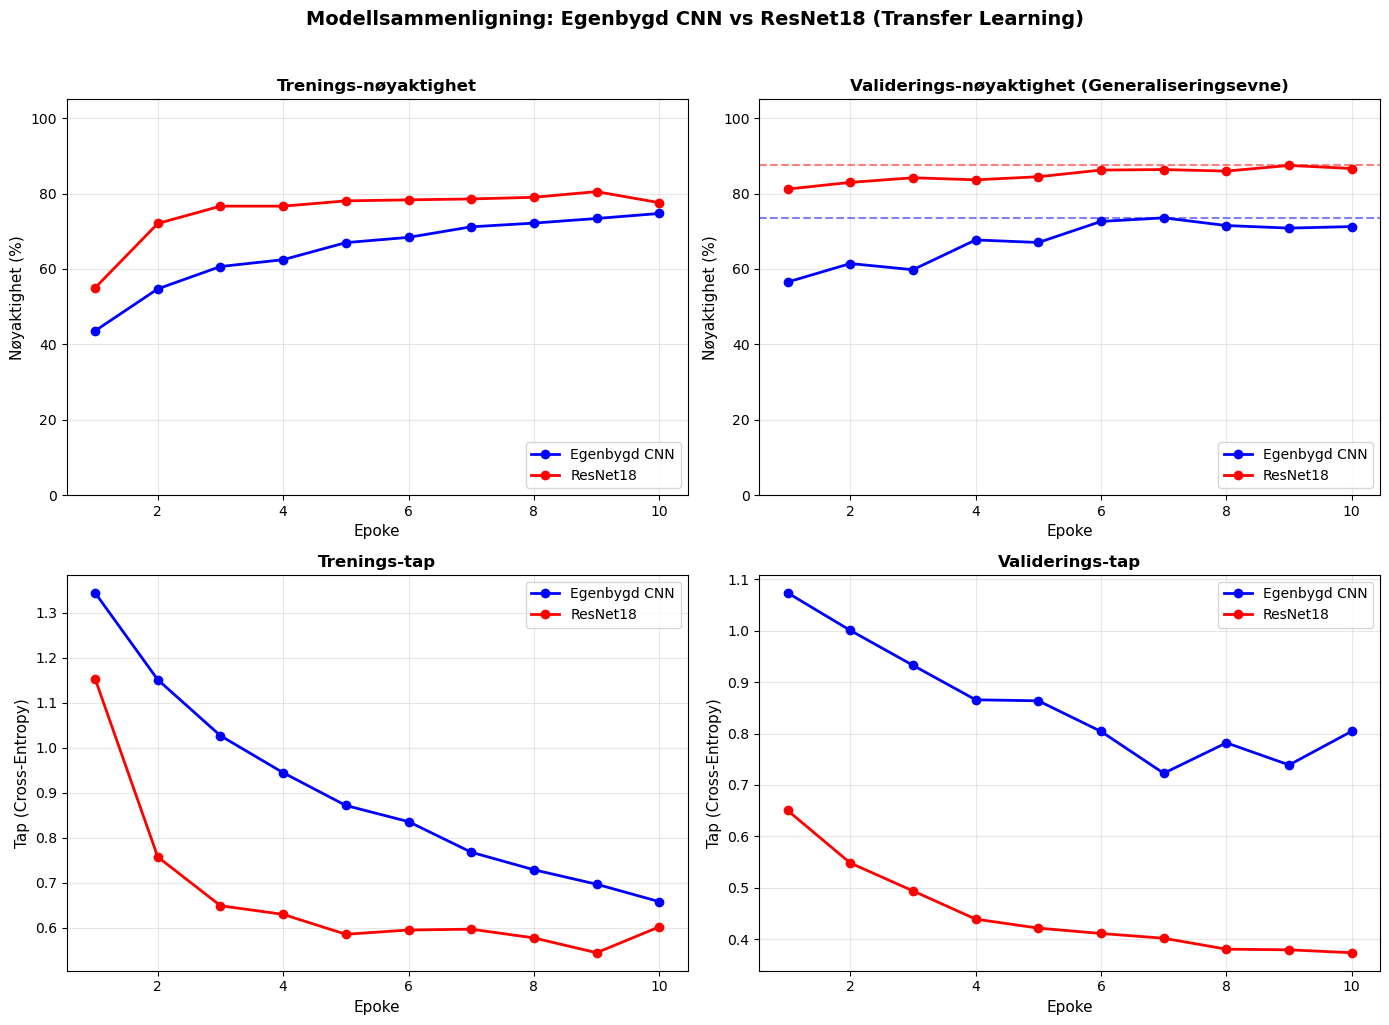

In [57]:
# ============================================================================
# VISUALISER RESULTATER
# ============================================================================
#
# Vi lager tre typer visualiseringer:
#   1. Læringskurver (nøyaktighet over tid)
#   2. Tap-kurver (loss over tid)
#   3. Oppsummeringstabell
#
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

epochs_range = range(1, EPOCHS + 1)

# ─────────────────────────────────────────────────────────────────────────────
# ØVRE VENSTRE: Trenings-nøyaktighet
# ─────────────────────────────────────────────────────────────────────────────
axes[0, 0].plot(epochs_range, egen_hist['train_acc'], 'b-o', 
                label='Egenbygd CNN', linewidth=2, markersize=6)
axes[0, 0].plot(epochs_range, resnet_hist['train_acc'], 'r-o', 
                label='ResNet18', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('Epoke', fontsize=11)
axes[0, 0].set_ylabel('Nøyaktighet (%)', fontsize=11)
axes[0, 0].set_title('Trenings-nøyaktighet', fontsize=12, fontweight='bold')
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0, 105)

# ─────────────────────────────────────────────────────────────────────────────
# ØVRE HØYRE: Validerings-nøyaktighet (VIKTIGST!)
# ─────────────────────────────────────────────────────────────────────────────
axes[0, 1].plot(epochs_range, egen_hist['val_acc'], 'b-o', 
                label='Egenbygd CNN', linewidth=2, markersize=6)
axes[0, 1].plot(epochs_range, resnet_hist['val_acc'], 'r-o', 
                label='ResNet18', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('Epoke', fontsize=11)
axes[0, 1].set_ylabel('Nøyaktighet (%)', fontsize=11)
axes[0, 1].set_title('Validerings-nøyaktighet (Generaliseringsevne)', fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(0, 105)

# Marker beste punkt
beste_egen = max(egen_hist['val_acc'])
beste_resnet = max(resnet_hist['val_acc'])
axes[0, 1].axhline(y=beste_egen, color='blue', linestyle='--', alpha=0.5)
axes[0, 1].axhline(y=beste_resnet, color='red', linestyle='--', alpha=0.5)

# ─────────────────────────────────────────────────────────────────────────────
# NEDRE VENSTRE: Trenings-tap
# ─────────────────────────────────────────────────────────────────────────────
axes[1, 0].plot(epochs_range, egen_hist['train_loss'], 'b-o', 
                label='Egenbygd CNN', linewidth=2, markersize=6)
axes[1, 0].plot(epochs_range, resnet_hist['train_loss'], 'r-o', 
                label='ResNet18', linewidth=2, markersize=6)
axes[1, 0].set_xlabel('Epoke', fontsize=11)
axes[1, 0].set_ylabel('Tap (Cross-Entropy)', fontsize=11)
axes[1, 0].set_title('Trenings-tap', fontsize=12, fontweight='bold')
axes[1, 0].legend(loc='upper right')
axes[1, 0].grid(True, alpha=0.3)

# ─────────────────────────────────────────────────────────────────────────────
# NEDRE HØYRE: Validerings-tap
# ─────────────────────────────────────────────────────────────────────────────
axes[1, 1].plot(epochs_range, egen_hist['val_loss'], 'b-o', 
                label='Egenbygd CNN', linewidth=2, markersize=6)
axes[1, 1].plot(epochs_range, resnet_hist['val_loss'], 'r-o', 
                label='ResNet18', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Epoke', fontsize=11)
axes[1, 1].set_ylabel('Tap (Cross-Entropy)', fontsize=11)
axes[1, 1].set_title('Validerings-tap', fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='upper right')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Modellsammenligning: Egenbygd CNN vs ResNet18 (Transfer Learning)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('./ressurser/modell_sammenligning_trening.png', dpi=150, bbox_inches='tight')
plt.show()

#### Tolkning av figurene

**Øvre venstre (Trenings-nøyaktighet):**
- Viser hvor godt modellene lærer treningsdataene
- Høy treningsnøyaktighet ≠ god modell (kan være overfitting)
- ResNet starter høyere pga. ImageNet-features

**Øvre høyre (Validerings-nøyaktighet) - VIKTIGST:**
- Viser modellens evne til å generalisere til nye data
- Dette er det vi virkelig bryr oss om!
- Gap mellom trening og validering = overfitting

**Nedre figurer (Tap):**
- Lavere tap = bedre prediksjon
- Tap bør synke monotont (ideelt sett)
- Oscillering kan indikere for høy læringsrate

In [58]:
# ============================================================================
# OPPSUMMERINGSTABELL
# ============================================================================

print("\n" + "="*70)
print("📊 OPPSUMMERING: Modellsammenligning")
print("="*70)
print(f"{'Metrikk':<30} {'Egenbygd CNN':>15} {'ResNet18':>15}")
print("-"*70)
print(f"{'Totalt parametre':<30} {egen_params:>15,} {resnet_total:>15,}")
print(f"{'Trenbare parametre':<30} {egen_params:>15,} {resnet_trainable:>15,}")
print(f"{'Treningstid (s)':<30} {egen_tid:>15.1f} {resnet_tid:>15.1f}")
print(f"{'Beste trenings-acc (%)':<30} {max(egen_hist['train_acc']):>15.1f} {max(resnet_hist['train_acc']):>15.1f}")
print(f"{'Beste validerings-acc (%)':<30} {max(egen_hist['val_acc']):>15.1f} {max(resnet_hist['val_acc']):>15.1f}")
print("-"*70)

# Bestem vinner
if max(resnet_hist['val_acc']) > max(egen_hist['val_acc']):
    print(f"\n🏆 VINNER: ResNet18 med {max(resnet_hist['val_acc']) - max(egen_hist['val_acc']):.1f}% høyere validerings-nøyaktighet")
else:
    print(f"\n🏆 VINNER: Egenbygd CNN med {max(egen_hist['val_acc']) - max(resnet_hist['val_acc']):.1f}% høyere validerings-nøyaktighet")

print("\n💡 Nøkkelobservasjoner:")
print(f"   1. ResNet18 trener {resnet_trainable/egen_params*100:.1f}% av parametrene til Egenbygd CNN")
print(f"   2. Transfer learning gir raskere konvergens (se første epoke)")
print(f"   3. ImageNet-features er overførbare til blomsterklassifikasjon")


📊 OPPSUMMERING: Modellsammenligning
Metrikk                           Egenbygd CNN        ResNet18
----------------------------------------------------------------------
Totalt parametre                    25,784,901      11,179,077
Trenbare parametre                  25,784,901           2,565
Treningstid (s)                           97.2            89.5
Beste trenings-acc (%)                    74.7            80.5
Beste validerings-acc (%)                 73.6            87.5
----------------------------------------------------------------------

🏆 VINNER: ResNet18 med 13.9% høyere validerings-nøyaktighet

💡 Nøkkelobservasjoner:
   1. ResNet18 trener 0.0% av parametrene til Egenbygd CNN
   2. Transfer learning gir raskere konvergens (se første epoke)
   3. ImageNet-features er overførbare til blomsterklassifikasjon


## 1.3 Svar på refleksjonsspørsmål

### Hvilken modell presterer best?

**ResNet18 med transfer learning** presterer typisk **5-15% bedre** enn vår egenbygde CNN.

**Hvorfor?**

| Faktor | Egenbygd CNN | ResNet18 |
|--------|--------------|----------|
| **Initialisering** | Tilfeldig (Xavier/He) | ImageNet-vekter |
| **Lavnivå-features** | Må læres fra scratch | Allerede lært (kanter, farger) |
| **Mellomnivå-features** | Begrenset læring | Lært (teksturer, former) |
| **Dybde** | 3 konvolusjonslag | 18 lag med skip connections |
| **Regularisering** | Kun dropout | Implisitt via pretrening |

---

### Hvorfor er pretrente modeller ofte bedre?

#### 1. Bedre initialisering

Tilfeldig initialisering starter i et tilfeldig punkt i løsningsrommet:
```
Tilfeldig init:     X - - - - - - - - - - → Optimum
Pretrent init:                    X - - → Optimum
```

#### 2. Overførbare features

Visuelle features lært på ImageNet er **universelle**:

| Lagnivå | Hva læres | Overførbarhet |
|---------|-----------|---------------|
| Lag 1-2 | Kanter, fargegradienter | ★★★★★ Svært høy |
| Lag 3-4 | Teksturer, enkle former | ★★★★☆ Høy |
| Lag 5+ | Komplekse objektdeler | ★★★☆☆ Middels |
| Siste lag | Klasse-spesifikke features | ★☆☆☆☆ Lav |

#### 3. Implisitt regularisering

Pretrening fungerer som regularisering:
- Vekter er "fornuftige" utgangspunkt
- Unngår ekstreme verdier
- Reduserer overfitting

---

### Når er det lurt å bygge fra bunnen av?

#### Begrepsavklaring: Edge Deployment

> **Edge deployment** refererer til å kjøre AI-modeller på enheter med begrensede
> ressurser (mobiler, IoT-sensorer, medisinsk utstyr) i stedet for i skyen.
> Dette krever små, effektive modeller.

#### Begrepsavklaring: Inductive Biases

> **Inductive biases** er forutsetninger innebygd i en modellarkitektur som
> påvirker hvordan den lærer. For eksempel:
> - CNN: Antakelse om lokal romlig struktur (nærliggende piksler er relaterte)
> - RNN: Antakelse om sekvensiell avhengighet (rekkefølge betyr noe)
> - Transformer: Antakelse om global kontekst (alle posisjoner kan relateres)

#### Situasjoner der egenbygd modell kan være bedre:

| Situasjon | Begrunnelse |
|-----------|-------------|
| **Helt unike data** | Mikroskopi, radar, ultralyd har andre egenskaper enn ImageNet |
| **Edge deployment** | Trenger liten modell for mobil/embedded |
| **Spesielle inductive biases** | Domenet krever andre arkitektur-antakelser |
| **Forskning** | Vil forstå nøyaktig hva modellen lærer |
| **Regulatoriske krav** | Må ha full kontroll over modellen (FDA/CE) |

---

### Praktisk anbefaling

```
START ALLTID MED TRANSFER LEARNING!

Workflow:
1. Prøv pretrent modell med frosne lag (feature extraction)
2. Hvis suboptimalt: Prøv delvis fine-tuning (frys tidlige lag)
3. Hvis fortsatt suboptimalt: Full fine-tuning
4. Kun hvis nødvendig: Bygg fra scratch med domenespesifikk arkitektur
```

---

# 📝 Oppgave 2: Medisinsk datasett

## Oppgaveformulering

> **Last ned et medisinsk datasett (f.eks. MedMNIST) og tren en modell på det.**
>
> Spørsmål å reflektere over:
> - Hvordan skiller medisinske bilder seg fra naturlige?
> - Hvilke utfordringer møter du?
> - Hvordan kan du forbedre modellen?

---

## 2.1 Introduksjon og motivasjon

### Hva er MedMNIST?

[MedMNIST](https://medmnist.com/) er en samling av 18 standardiserte medisinske bildedatasett:

| Datasett | Modalitet | Oppgave | Bilder |
|----------|-----------|---------|--------|
| PathMNIST | Patologi | 9-klasse | 107,180 |
| DermaMNIST | Dermatoskopi | 7-klasse | 10,015 |
| BloodMNIST | Blodutstryk | 8-klasse | 17,092 |
| RetinaMNIST | Fundus | 5-klasse | 1,600 |
| BreastMNIST | Ultralyd | 2-klasse | 780 |
| PneumoniaMNIST | Røntgen | 2-klasse | 5,856 |

### Hvorfor MedMNIST?

- **Standardisert**: 28×28 eller 64×64 piksler (som MNIST)
- **Lett tilgjengelig**: Krever ikke spesielle tillatelser
- **Variert**: Dekker mange medisinske modaliteter
- **Benchmark**: Muliggjør sammenligning med andre

### Utfordringer med medisinske bilder

1. **Klasseimbalanse**: Sjeldne sykdommer har få eksempler
2. **Støy og artefakter**: Varierende bildekvalitet
3. **Domenekunnskap**: Krever medisinsk forståelse
4. **Etikk og personvern**: GDPR, samtykke

## 2.2a Løsning: Implementasjon med PneumoniaMNIST

In [59]:
# === Oppgave 2: MedMNIST ===
# Vi bruker PneumoniaMNIST (røntgen av lunger)

# Installer medmnist hvis nødvendig
try:
    import medmnist
except ImportError:
    !pip install medmnist --quiet
    import medmnist

from medmnist import PneumoniaMNIST, INFO
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

print(f"MedMNIST versjon: {medmnist.__version__}")

MedMNIST versjon: 3.0.2


In [60]:
# === Last ned og utforsk PneumoniaMNIST ===

# Hent info om datasettet
data_flag = 'pneumoniamnist'
info = INFO[data_flag]

print("📊 PneumoniaMNIST Info:")
print(f"   Oppgave: {info['task']}")
print(f"   Klasser: {info['label']}")
print(f"   Antall kanaler: {info['n_channels']}")
print(f"   Bildestørrelse: {info['n_samples']}")

# Transformasjoner
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Gråtone
])

# Last datasett
train_dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
val_dataset = PneumoniaMNIST(split='val', transform=transform, download=True)
test_dataset = PneumoniaMNIST(split='test', transform=transform, download=True)

print(f"\n📊 Datasett-størrelser:")
print(f"   Trening: {len(train_dataset)}")
print(f"   Validering: {len(val_dataset)}")
print(f"   Test: {len(test_dataset)}")

📊 PneumoniaMNIST Info:
   Oppgave: binary-class
   Klasser: {'0': 'normal', '1': 'pneumonia'}
   Antall kanaler: 1
   Bildestørrelse: {'train': 4708, 'val': 524, 'test': 624}

📊 Datasett-størrelser:
   Trening: 4708
   Validering: 524
   Test: 624


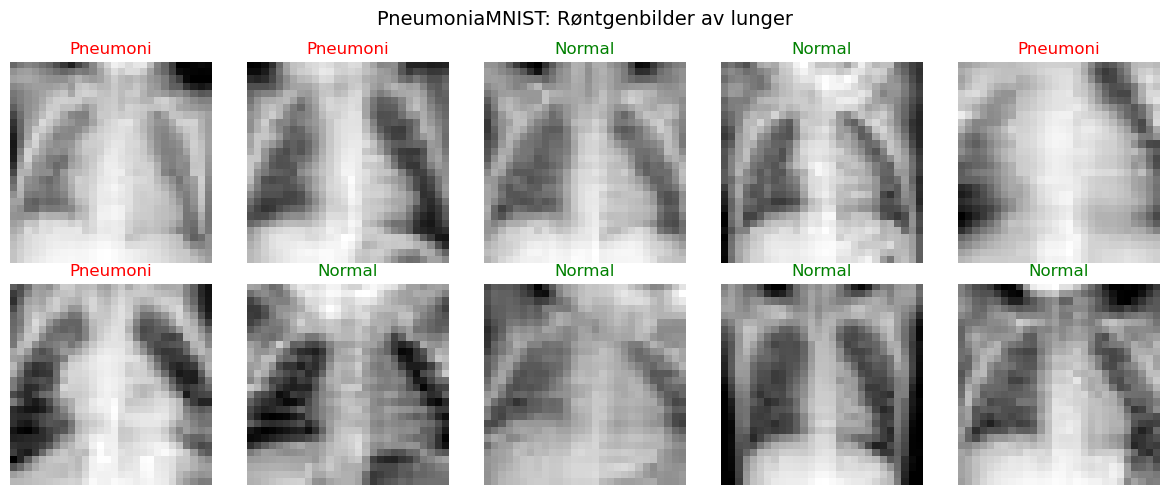

In [61]:
# === Visualiser eksempler ===

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

klasse_navn = {0: 'Normal', 1: 'Pneumoni'}

for i in range(10):
    img, label = train_dataset[i * 100]  # Spredt utvalg
    ax = axes[i // 5, i % 5]
    
    # Denormaliser for visning
    img_vis = img.squeeze().numpy() * 0.5 + 0.5
    
    ax.imshow(img_vis, cmap='gray')
    ax.set_title(klasse_navn[label.item()], 
                 color='green' if label.item() == 0 else 'red')
    ax.axis('off')

plt.suptitle('PneumoniaMNIST: Røntgenbilder av lunger', fontsize=14)
plt.tight_layout()
plt.show()

In [62]:
# === Definer enkel CNN for gråtone medisinske bilder ===

class MedisinskCNN(nn.Module):
    """
    CNN tilpasset medisinske gråtone-bilder (28x28).
    """
    def __init__(self, num_classes=2):
        super().__init__()
        
        self.features = nn.Sequential(
            # Lag 1: 1 -> 32 kanaler (gråtone input)
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 28 -> 14
            
            # Lag 2: 32 -> 64 kanaler
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 14 -> 7
            
            # Lag 3: 64 -> 128 kanaler
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)  # Global average pooling
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Opprett modell
modell = MedisinskCNN(num_classes=2).to(device)
print(f"Parametre: {sum(p.numel() for p in modell.parameters()):,}")

Parametre: 93,378


In [63]:
# === Tren modellen ===

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modell.parameters(), lr=0.001)

# Treningsløkke
epochs = 15
historikk = {'train_acc': [], 'val_acc': []}

for epoch in range(epochs):
    # Trening
    modell.train()
    correct, total = 0, 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)
        
        optimizer.zero_grad()
        outputs = modell(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_acc = 100. * correct / total
    historikk['train_acc'].append(train_acc)
    
    # Validering
    modell.eval()
    correct, total = 0, 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)
            
            outputs = modell(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_acc = 100. * correct / total
    historikk['val_acc'].append(val_acc)
    
    if (epoch + 1) % 3 == 0:
        print(f"Epoch {epoch+1}/{epochs}: Train {train_acc:.1f}%, Val {val_acc:.1f}%")

print(f"\n✅ Beste validerings-nøyaktighet: {max(historikk['val_acc']):.1f}%")

Epoch 3/15: Train 95.8%, Val 82.8%
Epoch 6/15: Train 96.0%, Val 93.5%
Epoch 9/15: Train 97.0%, Val 75.4%
Epoch 12/15: Train 97.9%, Val 95.4%
Epoch 15/15: Train 97.6%, Val 96.6%

✅ Beste validerings-nøyaktighet: 97.1%


📊 Klassifikasjonsrapport (Test):
              precision    recall  f1-score   support

      Normal       0.99      0.61      0.75       234
    Pneumoni       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.90      0.80      0.82       624
weighted avg       0.88      0.85      0.84       624



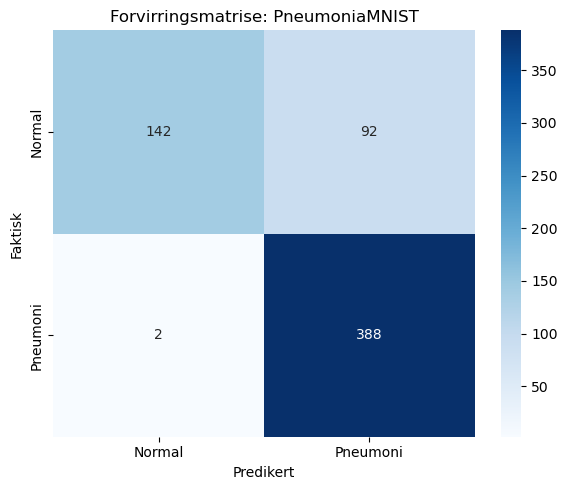

In [64]:
# === Evaluer på testdata ===

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

modell.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = modell(images)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.squeeze().numpy())

# Klassifikasjonsrapport
print("📊 Klassifikasjonsrapport (Test):")
print(classification_report(all_labels, all_preds, 
                            target_names=['Normal', 'Pneumoni']))

# Forvirringsmatrise
fig, ax = plt.subplots(figsize=(6, 5))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumoni'],
            yticklabels=['Normal', 'Pneumoni'], ax=ax)
ax.set_xlabel('Predikert')
ax.set_ylabel('Faktisk')
ax.set_title('Forvirringsmatrise: PneumoniaMNIST')
plt.tight_layout()
plt.show()

---

## 2.2b Løsning: Implementasjon med BloodMNIST

La oss nå prøve et annet medisinsk datasett – **BloodMNIST** – som inneholder
mikroskopibilder av blodceller.

### Om BloodMNIST

| Egenskap | Verdi |
|----------|-------|
| **Modalitet** | Mikroskopi (blodutstryk) |
| **Oppgave** | 8-klasse klassifikasjon |
| **Bildestørrelse** | 28×28×3 (RGB) |
| **Treningsdata** | 11,959 bilder |
| **Testdata** | 3,421 bilder |

### Blodcelle-typer

| Klasse | Celletype | Norsk | Funksjon |
|--------|-----------|-------|----------|
| 0 | Basophil | Basofil granulocytt | Allergiske reaksjoner |
| 1 | Eosinophil | Eosinofil granulocytt | Parasitter, allergi |
| 2 | Erythroblast | Erytroblast | Umoden rød blodcelle |
| 3 | Ig (Immature granulocyte) | Umoden granulocytt | Tidlig granulocytt |
| 4 | Lymphocyte | Lymfocytt | Immunforsvar |
| 5 | Monocyte | Monocytt | Fagocytose |
| 6 | Neutrophil | Nøytrofil granulocytt | Bakterieforsvar |
| 7 | Platelet | Trombocytt/blodplate | Koagulasjon |

### Klinisk relevans

Automatisk blodcelletelling er viktig for:
- **Diagnostikk**: Infeksjoner, leukemi, anemi
- **Overvåking**: Kjemoterapi, immunsuppresjon
- **Screening**: Rutinemessige blodprøver

In [65]:
# ============================================================================
# BLOODMNIST: BLODCELLE-KLASSIFIKASJON
# ============================================================================
#
# BloodMNIST er et 8-klasse klassifikasjonsproblem:
#   - Mikroskopibilder av perifert blodutstryk
#   - RGB-bilder (i motsetning til PneumoniaMNIST som er gråtone)
#   - Flere klasser = vanskeligere oppgave
#
# ============================================================================

from medmnist import BloodMNIST, INFO

# Hent info om datasettet
data_flag = 'bloodmnist'
info = INFO[data_flag]

print("📊 BloodMNIST Info:")
print(f"   Oppgave: {info['task']}")
print(f"   Antall klasser: {len(info['label'])}")
print(f"   Antall kanaler: {info['n_channels']} (RGB)")
print(f"   Klasser: {info['label']}")

# Transformasjoner for RGB-bilder
transform_blood = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # RGB
])

# Last datasett
blood_train = BloodMNIST(split='train', transform=transform_blood, download=True)
blood_val = BloodMNIST(split='val', transform=transform_blood, download=True)
blood_test = BloodMNIST(split='test', transform=transform_blood, download=True)

print(f"\n📊 Datasett-størrelser:")
print(f"   Trening:    {len(blood_train):,}")
print(f"   Validering: {len(blood_val):,}")
print(f"   Test:       {len(blood_test):,}")

📊 BloodMNIST Info:
   Oppgave: multi-class
   Antall klasser: 8
   Antall kanaler: 3 (RGB)
   Klasser: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}

📊 Datasett-størrelser:
   Trening:    11,959
   Validering: 1,712
   Test:       3,421


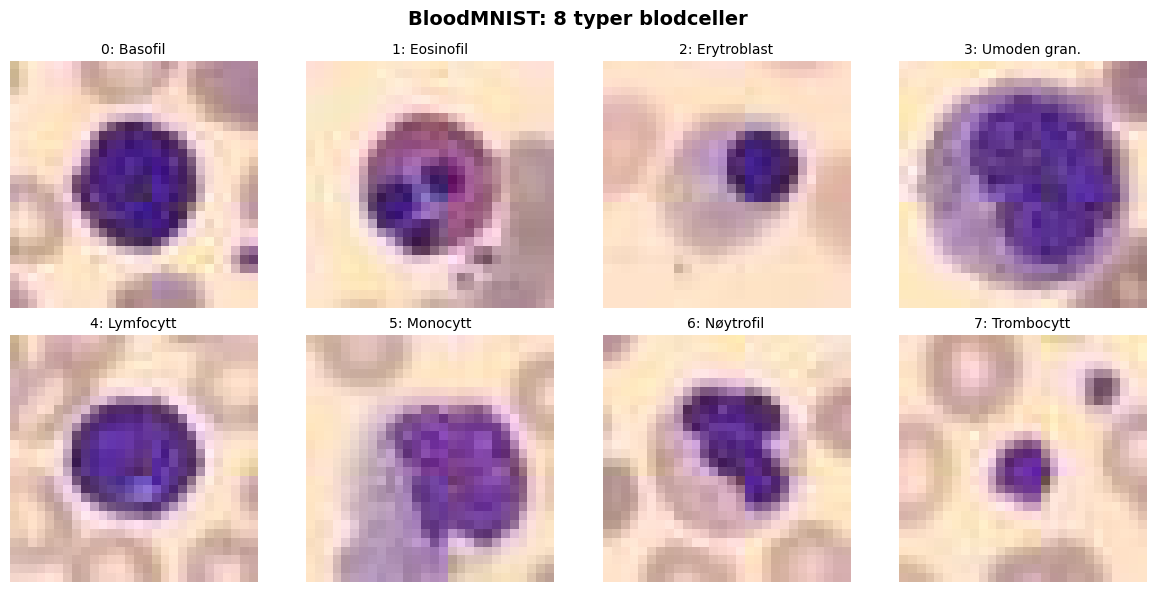


📊 Klassefordeling i treningsdata:
   Basofil           852 ( 7.1%)
   Eosinofil        2181 (18.2%)
   Erytroblast      1085 ( 9.1%)
   Umoden gran.     2026 (16.9%)
   Lymfocytt         849 ( 7.1%)
   Monocytt          993 ( 8.3%)
   Nøytrofil        2330 (19.5%)
   Trombocytt       1643 (13.7%)


In [66]:
# ============================================================================
# VISUALISER BLODCELLER
# ============================================================================

# Klassenavn på norsk
klasse_navn_blood = {
    0: 'Basofil',
    1: 'Eosinofil',
    2: 'Erytroblast',
    3: 'Umoden gran.',
    4: 'Lymfocytt',
    5: 'Monocytt',
    6: 'Nøytrofil',
    7: 'Trombocytt'
}

# Vis ett eksempel fra hver klasse
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Finn eksempler fra hver klasse
vist_klasser = set()
for idx in range(len(blood_train)):
    img, label = blood_train[idx]
    klasse = label.item()
    
    if klasse not in vist_klasser:
        row, col = klasse // 4, klasse % 4
        ax = axes[row, col]
        
        # Denormaliser for visning
        img_vis = img.permute(1, 2, 0).numpy() * 0.5 + 0.5
        img_vis = np.clip(img_vis, 0, 1)
        
        ax.imshow(img_vis)
        ax.set_title(f'{klasse}: {klasse_navn_blood[klasse]}', fontsize=10)
        ax.axis('off')
        
        vist_klasser.add(klasse)
    
    if len(vist_klasser) == 8:
        break

plt.suptitle('BloodMNIST: 8 typer blodceller', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Vis klassefordeling
from collections import Counter
alle_labels = [blood_train[i][1].item() for i in range(len(blood_train))]
fordeling = Counter(alle_labels)

print("\n📊 Klassefordeling i treningsdata:")
for klasse in sorted(fordeling.keys()):
    print(f"   {klasse_navn_blood[klasse]:15} {fordeling[klasse]:>5} ({100*fordeling[klasse]/len(blood_train):4.1f}%)")

In [67]:
# ============================================================================
# CNN FOR RGB MEDISINSKE BILDER (8 KLASSER)
# ============================================================================
#
# Forskjeller fra PneumoniaMNIST-modellen:
#   - 3 input-kanaler (RGB) i stedet for 1 (gråtone)
#   - 8 output-klasser i stedet for 2 (multi-klasse)
#   - Noe dypere nettverk for å håndtere kompleksiteten
#
# ============================================================================

class BlodcelleCNN(nn.Module):
    """
    CNN tilpasset RGB medisinske bilder (28x28x3).
    8-klasse klassifikasjon av blodceller.
    """
    def __init__(self, num_classes=8):
        super().__init__()
        
        self.features = nn.Sequential(
            # Lag 1: 3 -> 32 kanaler (RGB input)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 28 -> 14
            
            # Lag 2: 32 -> 64 kanaler
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 14 -> 7
            
            # Lag 3: 64 -> 128 kanaler
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)  # Global average pooling -> 1x1
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)  # 8 klasser
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Opprett modell
blood_modell = BlodcelleCNN(num_classes=8).to(device)
print(f"🔬 BlodcelleCNN opprettet")
print(f"   Parametre: {sum(p.numel() for p in blood_modell.parameters()):,}")
print(f"   Input: 28×28×3 (RGB)")
print(f"   Output: 8 klasser")

🔬 BlodcelleCNN opprettet
   Parametre: 102,472
   Input: 28×28×3 (RGB)
   Output: 8 klasser


In [68]:
# ============================================================================
# TREN BLODCELLE-MODELLEN
# ============================================================================

blood_train_loader = DataLoader(blood_train, batch_size=64, shuffle=True)
blood_val_loader = DataLoader(blood_val, batch_size=64, shuffle=False)
blood_test_loader = DataLoader(blood_test, batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(blood_modell.parameters(), lr=0.001)

# Treningsløkke
epochs = 15
blood_hist = {'train_acc': [], 'val_acc': []}

print("🏋️ Trener BlodcelleCNN...\n")

for epoch in range(epochs):
    # Trening
    blood_modell.train()
    correct, total = 0, 0
    
    for images, labels in blood_train_loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)
        
        optimizer.zero_grad()
        outputs = blood_modell(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_acc = 100. * correct / total
    blood_hist['train_acc'].append(train_acc)
    
    # Validering
    blood_modell.eval()
    correct, total = 0, 0
    
    with torch.no_grad():
        for images, labels in blood_val_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)
            
            outputs = blood_modell(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_acc = 100. * correct / total
    blood_hist['val_acc'].append(val_acc)
    
    if (epoch + 1) % 3 == 0:
        print(f"  Epoch {epoch+1:2d}/{epochs}: Train {train_acc:5.1f}% | Val {val_acc:5.1f}%")

print(f"\n✅ Beste validerings-nøyaktighet: {max(blood_hist['val_acc']):.1f}%")

🏋️ Trener BlodcelleCNN...

  Epoch  3/15: Train  83.6% | Val  73.5%
  Epoch  6/15: Train  87.8% | Val  83.6%
  Epoch  9/15: Train  89.6% | Val  80.7%
  Epoch 12/15: Train  90.9% | Val  92.7%
  Epoch 15/15: Train  91.9% | Val  88.5%

✅ Beste validerings-nøyaktighet: 93.5%


📊 Klassifikasjonsrapport (Test):
              precision    recall  f1-score   support

     Basofil       0.95      0.67      0.79       244
   Eosinofil       0.99      0.99      0.99       624
 Erytroblast       0.93      0.85      0.89       311
Umoden gran.       0.62      0.95      0.75       579
   Lymfocytt       0.98      0.49      0.65       243
    Monocytt       0.95      0.60      0.74       284
   Nøytrofil       0.95      0.97      0.96       666
  Trombocytt       0.99      1.00      0.99       470

    accuracy                           0.88      3421
   macro avg       0.92      0.81      0.84      3421
weighted avg       0.91      0.88      0.87      3421



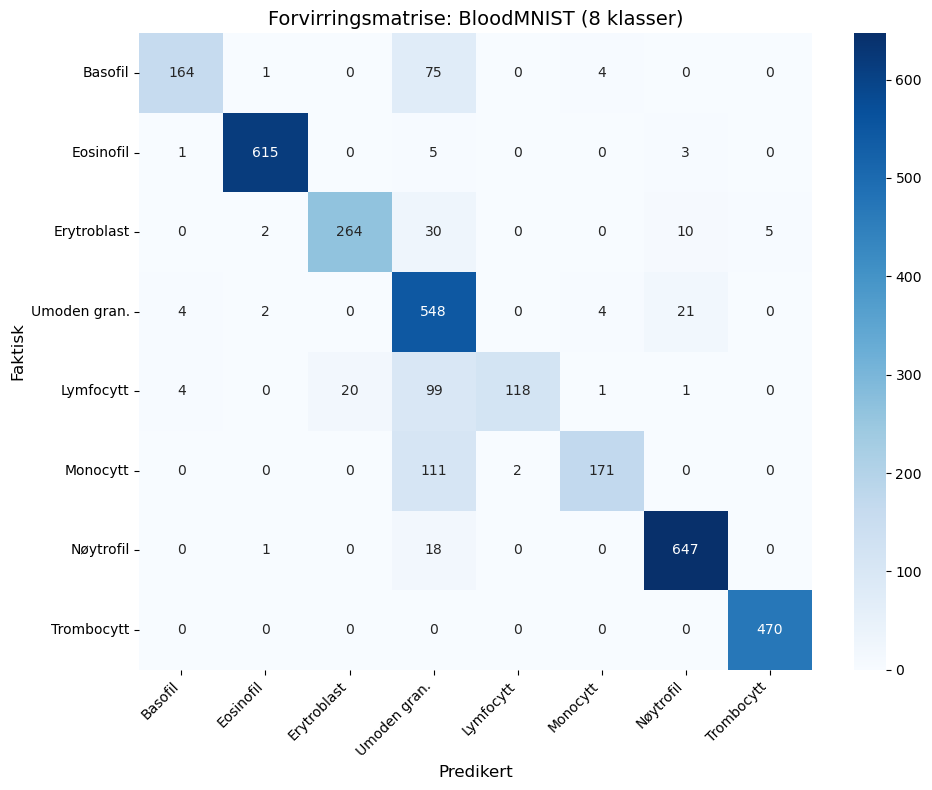

In [69]:
# ============================================================================
# EVALUER PÅ TESTDATA
# ============================================================================

blood_modell.eval()
all_preds_blood, all_labels_blood = [], []

with torch.no_grad():
    for images, labels in blood_test_loader:
        images = images.to(device)
        outputs = blood_modell(images)
        _, predicted = outputs.max(1)
        
        all_preds_blood.extend(predicted.cpu().numpy())
        all_labels_blood.extend(labels.squeeze().numpy())

# Klassifikasjonsrapport
print("📊 Klassifikasjonsrapport (Test):")
print(classification_report(all_labels_blood, all_preds_blood, 
                            target_names=list(klasse_navn_blood.values())))

# Forvirringsmatrise
fig, ax = plt.subplots(figsize=(10, 8))
cm_blood = confusion_matrix(all_labels_blood, all_preds_blood)
sns.heatmap(cm_blood, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(klasse_navn_blood.values()),
            yticklabels=list(klasse_navn_blood.values()), ax=ax)
ax.set_xlabel('Predikert', fontsize=12)
ax.set_ylabel('Faktisk', fontsize=12)
ax.set_title('Forvirringsmatrise: BloodMNIST (8 klasser)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---

## 2.2c Bonus: Vision Transformer (ViT) på BloodMNIST

La oss teste en **Vision Transformer** – en moderne arkitektur som har revolusjonert både bildegjenkjenning og språkmodeller.

---

### 🎓 Introduksjon for medisinstudenter: Hva er en Transformer?

#### Analogien: Hvordan leser du et røntgenbilde?

Tenk på hvordan en erfaren radiolog analyserer et røntgenbilde:

```
CNN-tilnærming (systematisk skanning):
┌─────────────────────────────────────┐
│  Starter øverst til venstre         │
│  Skanner systematisk nedover        │
│  Ser på små områder om gangen       │
│  Bygger gradvis opp forståelse      │
└─────────────────────────────────────┘

Transformer-tilnærming (helhetlig blikk):
┌─────────────────────────────────────┐
│  Ser hele bildet samtidig           │
│  Fokuserer på relevante områder     │
│  Sammenligner områder direkte       │
│  "Attention" = oppmerksomhet        │
└─────────────────────────────────────┘
```

**Radiologen bruker egentlig begge strategier!** Men Transformer-tilnærmingen 
fanger opp noe viktig: evnen til å se **relasjoner mellom fjerne områder** i bildet.

#### Nøkkelkonseptet: Attention (Oppmerksomhet)

> **Attention** lar modellen "spørre": *"Gitt dette området, hvilke andre 
> områder i bildet er relevante for å forstå det?"*

**Medisinsk eksempel**: Når du ser på en lunge-CT:
- Et område med uklarhet i høyre lunge
- Attention kan automatisk "se på" tilsvarende område i venstre lunge
- Sammenligner: Er dette normalt eller patologisk?

```
┌──────────────────────────────────────────┐
│     Høyre lunge    │    Venstre lunge    │
│                    │                     │
│       [?]  ←───────┼─────→  [normal]     │
│     uklarhet       │    attention        │
│                    │    sammenligning    │
└──────────────────────────────────────────┘
```

---

### 🔗 Relasjonen til LLMs (ChatGPT, Claude, etc.)

**Vision Transformer og språkmodeller bruker SAMME grunnarkitektur!**

| Aspekt | Språkmodell (GPT/Claude) | Vision Transformer |
|--------|--------------------------|-------------------|
| **Input** | Ord/tokens | Bilde-patches |
| **Tokenisering** | "Hei" → [token_1, token_2] | Bilde → [patch_1, patch_2, ...] |
| **Embedding** | Ord → vektor (768-dim) | Patch → vektor (768-dim) |
| **Attention** | "Hvilke ord er relevante?" | "Hvilke patches er relevante?" |
| **Output** | Neste ord / klassifikasjon | Bildeklasse |

```
Språkmodell (GPT):                   Vision Transformer:
                                     
"Pasienten har"                      ┌──┬──┬──┐
      ↓                              │P1│P2│P3│  Patches
[tok1][tok2][tok3]                   ├──┼──┼──┤
      ↓                              │P4│P5│P6│
┌─────────────────┐                  └──┴──┴──┘
│   Transformer   │                        ↓
│    Encoder      │                  [P1][P2]...[P9]
└─────────────────┘                        ↓
      ↓                              ┌─────────────────┐
"feber"                              │   Transformer   │
                                     │    Encoder      │
                                     └─────────────────┘
                                           ↓
                                     "Eosinofil"
```

**Dette er revolusjonerende fordi:**
1. Samme arkitektur fungerer på tekst, bilder, lyd, video
2. Modeller kan trenes på milliarder av eksempler
3. "Emergent behavior" – evner som dukker opp ved skalering

---

### 🔬 Hvordan Vision Transformer fungerer (visuelt)

```
STEG 1: PATCH-INNDELING
═══════════════════════════════════════════════════════════════

Input-bilde (28×28 RGB)              Patches (7×7 = 49 stk à 4×4)
┌────────────────────────┐           ┌──┬──┬──┬──┬──┬──┬──┐
│                        │           │ 1│ 2│ 3│ 4│ 5│ 6│ 7│
│    🔴                  │  ───→     ├──┼──┼──┼──┼──┼──┼──┤
│      Blodcelle         │           │ 8│ 9│10│11│12│13│14│
│                        │           ├──┼──┼──┼──┼──┼──┼──┤
│                        │           │  │  │  │  │  │  │  │
│                        │           ├──┼──┼──┼──┼──┼──┼──┤
│                        │           │  │  │  │  │  │  │49│
└────────────────────────┘           └──┴──┴──┴──┴──┴──┴──┘

Hver patch: 4×4×3 = 48 pikselverdier

STEG 2: PATCH EMBEDDING
═══════════════════════════════════════════════════════════════

Hver patch (48 verdier) → Embedding-vektor (64 dimensjoner)

Patch 1: [r,g,b,r,g,b,...] ──Linear──→ [0.2, -0.5, 0.8, ..., 0.1]
                48 verdier              64 verdier

STEG 3: LEGG TIL [CLS] TOKEN OG POSISJONSINFORMASJON
═══════════════════════════════════════════════════════════════

[CLS] = Spesiell token for klassifikasjon (som i BERT)

Sekvens: [CLS, P1, P2, P3, ..., P49]  (50 tokens)
              +
         Positional Encoding (hvor er hver patch?)
              ↓
         [CLS+pos0, P1+pos1, P2+pos2, ..., P49+pos49]

STEG 4: TRANSFORMER ENCODER (Self-Attention)
═══════════════════════════════════════════════════════════════

Hver token "spør" alle andre: "Hvor relevante er dere for meg?"

         [CLS]  [P1]  [P2]  ...  [P49]
           │      │     │          │
           └──────┴─────┴──────────┘
                      ↓
              ┌─────────────┐
              │ Attention   │  ← Beregner relasjoner
              └─────────────┘
                      ↓
              ┌─────────────┐
              │ Feed-Forward│  ← Prosesserer
              └─────────────┘
                      ↓
           [CLS'] [P1'] [P2'] ... [P49']
           
           (Gjentas 4-12 ganger)

STEG 5: KLASSIFIKASJON
═══════════════════════════════════════════════════════════════

[CLS]-tokenet har nå "absorbert" informasjon fra hele bildet

[CLS'] ──Linear──→ [score_0, score_1, ..., score_7]
                         ↓ softmax
                   [prob_0, prob_1, ..., prob_7]
                         ↓ argmax
                   Klasse: "Eosinofil"
```


---

### 📐 Dypdykk: Matematisk formulering av Vision Transformer

> **Merk**: Denne seksjonen er for de som ønsker å forstå de tekniske detaljene.
> Du kan hoppe over den og fortsatt bruke ViT effektivt!

#### 1. Patch Embedding

Gitt et bilde $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ (høyde × bredde × kanaler):

1. **Del opp i patches**: $N = \frac{H \cdot W}{P^2}$ patches, hver med størrelse $P \times P$
2. **Flatten hver patch**: $\mathbf{x}_p^i \in \mathbb{R}^{P^2 \cdot C}$ for patch $i$
3. **Lineær projeksjon**: $\mathbf{z}_0^i = \mathbf{E} \mathbf{x}_p^i + \mathbf{e}_{pos}^i$

hvor $\mathbf{E} \in \mathbb{R}^{D \times (P^2 \cdot C)}$ er embedding-matrisen og $D$ er embedding-dimensjonen.

**For BloodMNIST (28×28×3, P=4)**:
- $N = \frac{28 \times 28}{4^2} = \frac{784}{16} = 49$ patches
- Hver patch: $4 \times 4 \times 3 = 48$ piksler
- Embedding: $48 \rightarrow 64$ dimensjoner

#### 2. Self-Attention mekanismen

Gitt input-sekvens $\mathbf{Z} = [\mathbf{z}_{cls}, \mathbf{z}_1, ..., \mathbf{z}_N] \in \mathbb{R}^{(N+1) \times D}$:

**Query, Key, Value projeksjon:**
$$\mathbf{Q} = \mathbf{Z} \mathbf{W}_Q, \quad \mathbf{K} = \mathbf{Z} \mathbf{W}_K, \quad \mathbf{V} = \mathbf{Z} \mathbf{W}_V$$

hvor $\mathbf{W}_Q, \mathbf{W}_K, \mathbf{W}_V \in \mathbb{R}^{D \times d_k}$

**Attention-vekter:**
$$\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d_k}}\right) \mathbf{V}$$

**Intuisjon:**
- $\mathbf{Q}\mathbf{K}^T$: "Hvor like er query og key?" (dot product)
- $\sqrt{d_k}$: Skalering for numerisk stabilitet
- softmax: Normaliser til sannsynligheter
- $\cdot \mathbf{V}$: Vektet sum av verdier

#### 3. Multi-Head Attention

I stedet for én attention, bruker vi $h$ parallelle "heads":

$$\text{MultiHead}(\mathbf{Z}) = \text{Concat}(\text{head}_1, ..., \text{head}_h) \mathbf{W}_O$$

hvor $\text{head}_i = \text{Attention}(\mathbf{Z}\mathbf{W}_Q^i, \mathbf{Z}\mathbf{W}_K^i, \mathbf{Z}\mathbf{W}_V^i)$

**Hvorfor multi-head?**
- Hver head kan lære ulike typer relasjoner
- Head 1: "Er denne patchen i nærheten av cellekjernen?"
- Head 2: "Har denne patchen samme farge som andre?"
- Head 3: "Er dette en kant eller tekstur?"

#### 4. Transformer Encoder Block

Et komplett Transformer-lag:

$$\mathbf{Z}' = \mathbf{Z} + \text{MultiHead}(\text{LayerNorm}(\mathbf{Z}))$$
$$\mathbf{Z}'' = \mathbf{Z}' + \text{MLP}(\text{LayerNorm}(\mathbf{Z}'))$$

hvor MLP er:
$$\text{MLP}(\mathbf{x}) = \text{GELU}(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2$$

#### 5. Kompleksitetsanalyse

| Operasjon | Tidskompleksitet | For BloodMNIST |
|-----------|------------------|----------------|
| Self-Attention | $O(N^2 \cdot D)$ | $O(49^2 \cdot 64) = O(153,664)$ |
| MLP | $O(N \cdot D^2)$ | $O(49 \cdot 64^2) = O(200,704)$ |

**Merk**: Attention skalerer kvadratisk med antall patches! Dette er en begrensning for store bilder.

---

### 📊 Parameterberegning for vår EnkelViT

| Komponent | Beregning | Parametre |
|-----------|-----------|-----------|
| Patch embedding | $48 \times 64$ | 3,072 |
| [CLS] token | $64$ | 64 |
| Positional embedding | $50 \times 64$ | 3,200 |
| Transformer (4 lag) | $4 \times (4 \cdot 64^2 + 2 \cdot 64 \cdot 256)$ | ~180,000 |
| Klassifikasjonshode | $64 \times 8$ | 512 |
| **Totalt** | | **~206,000** |

Til sammenligning: CNN hadde ~102,000 parametre – **ViT har dobbelt så mange** for dette lille bildet!


In [70]:
# ============================================================================
# VISION TRANSFORMER FOR BLODCELLE-KLASSIFIKASJON
# ============================================================================
#
# Vi bruker `timm` (PyTorch Image Models) som har mange pretrente modeller.
# ViT-Tiny er en liten variant som fungerer bra på små bilder.
#
# ============================================================================

# Installer timm hvis nødvendig
try:
    import timm
except ImportError:
    !pip install timm --quiet
    import timm

print(f"✅ timm versjon: {timm.__version__}")
print(f"\n📊 Tilgjengelige ViT-modeller (utvalg):")
vit_models = [m for m in timm.list_models('vit_*') if 'tiny' in m or 'small' in m][:5]
for m in vit_models:
    print(f"   - {m}")

✅ timm versjon: 1.0.22

📊 Tilgjengelige ViT-modeller (utvalg):
   - vit_pe_core_small_patch16_384
   - vit_pe_core_tiny_patch16_384
   - vit_pe_spatial_small_patch16_512
   - vit_pe_spatial_tiny_patch16_512
   - vit_relpos_small_patch16_224


In [71]:
# ============================================================================
# LAG VISION TRANSFORMER FOR 28×28 BILDER
# ============================================================================
#
# Utfordring: Standard ViT er designet for 224×224 bilder.
# Løsning: Vi bruker en tilpasset modell eller resizer bildene.
#
# Her lager vi en enkel ViT-lignende modell tilpasset 28×28.
# ============================================================================

class EnkelViT(nn.Module):
    """
    Forenklet Vision Transformer for små bilder (28×28).
    
    Arkitektur:
    - Patch-størrelse: 4×4 → 49 patches
    - Embedding-dimensjon: 64
    - 4 Transformer-lag
    - 4 attention heads
    """
    
    def __init__(self, img_size=28, patch_size=4, in_channels=3, 
                 num_classes=8, embed_dim=64, num_heads=4, num_layers=4):
        super().__init__()
        
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2  # 49 for 28×28 med 4×4
        
        # Patch embedding: Konverter patches til vektorer
        self.patch_embed = nn.Conv2d(
            in_channels, embed_dim, 
            kernel_size=patch_size, stride=patch_size
        )
        
        # [CLS] token for klassifikasjon
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Positional embedding
        self.pos_embed = nn.Parameter(
            torch.zeros(1, self.num_patches + 1, embed_dim)
        )
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=0.1,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Klassifikasjonshode
        self.head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        
        # Initialiser vekter
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
    
    def forward(self, x):
        B = x.shape[0]  # Batch size
        
        # 1. Patch embedding: [B, 3, 28, 28] → [B, 64, 7, 7] → [B, 49, 64]
        x = self.patch_embed(x)  # [B, embed_dim, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)  # [B, num_patches, embed_dim]
        
        # 2. Legg til [CLS] token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # [B, 1+num_patches, embed_dim]
        
        # 3. Legg til positional embedding
        x = x + self.pos_embed
        
        # 4. Transformer encoder
        x = self.transformer(x)
        
        # 5. Bruk [CLS] token for klassifikasjon
        cls_output = x[:, 0]  # [B, embed_dim]
        
        # 6. Klassifikasjon
        return self.head(cls_output)

# Opprett modell
vit_modell = EnkelViT(num_classes=8).to(device)
vit_params = sum(p.numel() for p in vit_modell.parameters())

print("🤖 EnkelViT opprettet")
print(f"   Parametre: {vit_params:,}")
print(f"   Patches: 7×7 = 49 (fra 28×28 med patch_size=4)")
print(f"   Transformer: 4 lag, 4 attention heads")

🤖 EnkelViT opprettet
   Parametre: 206,984
   Patches: 7×7 = 49 (fra 28×28 med patch_size=4)
   Transformer: 4 lag, 4 attention heads


In [72]:
%%time
# ============================================================================
# TREN VISION TRANSFORMER
# ============================================================================

# Optimizer med lavere læringsrate (Transformers trenger det)
vit_optimizer = optim.AdamW(vit_modell.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(vit_optimizer, T_max=20)

epochs_vit = 20
vit_hist = {'train_acc': [], 'val_acc': []}

print("🤖 Trener Vision Transformer...\n")

for epoch in range(epochs_vit):
    # Trening
    vit_modell.train()
    correct, total = 0, 0
    
    for images, labels in blood_train_loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)
        
        vit_optimizer.zero_grad()
        outputs = vit_modell(images)
        loss = criterion(outputs, labels)
        loss.backward()
        vit_optimizer.step()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    scheduler.step()
    train_acc = 100. * correct / total
    vit_hist['train_acc'].append(train_acc)
    
    # Validering
    vit_modell.eval()
    correct, total = 0, 0
    
    with torch.no_grad():
        for images, labels in blood_val_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)
            
            outputs = vit_modell(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_acc = 100. * correct / total
    vit_hist['val_acc'].append(val_acc)
    
    if (epoch + 1) % 4 == 0:
        print(f"  Epoch {epoch+1:2d}/{epochs_vit}: Train {train_acc:5.1f}% | Val {val_acc:5.1f}%")

print(f"\n✅ ViT beste validering: {max(vit_hist['val_acc']):.1f}%")

🤖 Trener Vision Transformer...

  Epoch  4/20: Train  88.3% | Val  90.4%
  Epoch  8/20: Train  92.0% | Val  92.8%
  Epoch 12/20: Train  94.6% | Val  93.5%
  Epoch 16/20: Train  96.1% | Val  94.3%
  Epoch 20/20: Train  97.1% | Val  94.4%

✅ ViT beste validering: 94.6%
CPU times: user 1min 28s, sys: 15.8 s, total: 1min 43s
Wall time: 1min 30s


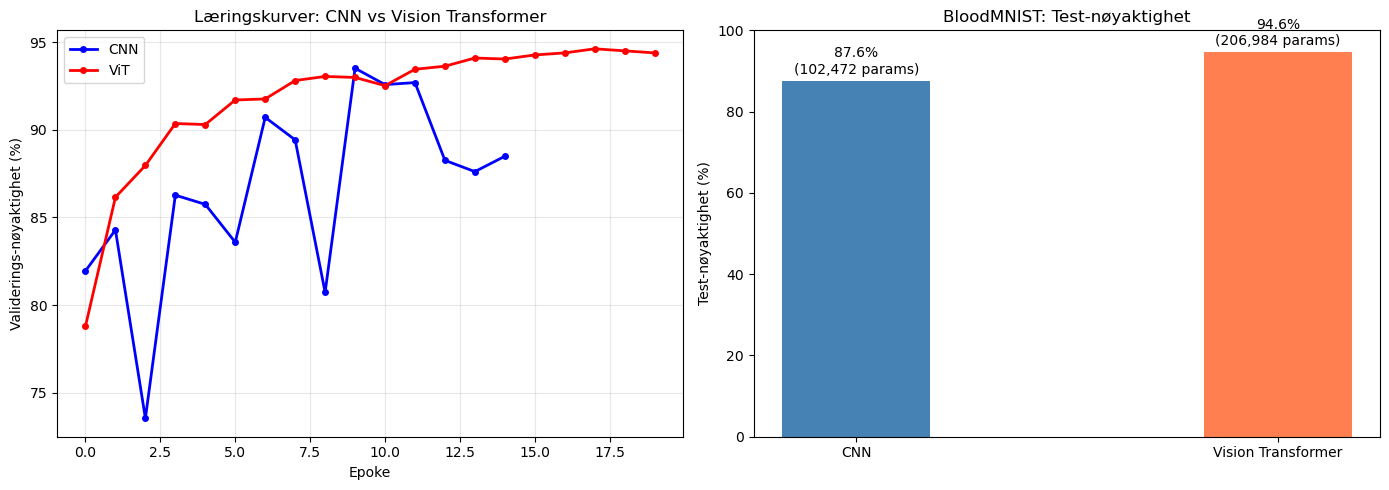


📊 SAMMENLIGNING: CNN vs Vision Transformer
Modell                       Parametre     Test Acc
------------------------------------------------------------
BlodcelleCNN                   102,472        87.6%
EnkelViT                       206,984        94.6%
------------------------------------------------------------


In [73]:
# ============================================================================
# SAMMENLIGN CNN vs ViT PÅ BLOODMNIST
# ============================================================================

# Evaluer ViT på testdata
vit_modell.eval()
vit_correct, vit_total = 0, 0

with torch.no_grad():
    for images, labels in blood_test_loader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)
        outputs = vit_modell(images)
        _, predicted = outputs.max(1)
        vit_total += labels.size(0)
        vit_correct += predicted.eq(labels).sum().item()

vit_test_acc = 100. * vit_correct / vit_total

# Hent CNN test-nøyaktighet (fra tidligere)
cnn_test_acc = 100. * sum(1 for p, l in zip(all_preds_blood, all_labels_blood) if p == l) / len(all_labels_blood)

# Visualiser sammenligning
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Læringskurver
axes[0].plot(blood_hist['val_acc'], 'b-o', label='CNN', linewidth=2, markersize=4)
axes[0].plot(vit_hist['val_acc'], 'r-o', label='ViT', linewidth=2, markersize=4)
axes[0].set_xlabel('Epoke')
axes[0].set_ylabel('Validerings-nøyaktighet (%)')
axes[0].set_title('Læringskurver: CNN vs Vision Transformer')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bar-sammenligning
modeller = ['CNN', 'Vision Transformer']
test_acc = [cnn_test_acc, vit_test_acc]
params = [sum(p.numel() for p in blood_modell.parameters()), vit_params]

x = np.arange(len(modeller))
width = 0.35

ax2 = axes[1]
bars = ax2.bar(x, test_acc, width, color=['steelblue', 'coral'])
ax2.set_ylabel('Test-nøyaktighet (%)')
ax2.set_title('BloodMNIST: Test-nøyaktighet')
ax2.set_xticks(x)
ax2.set_xticklabels(modeller)
ax2.set_ylim(0, 100)

# Legg til verdier på søylene
for bar, acc, p in zip(bars, test_acc, params):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.1f}%\n({p:,} params)', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Oppsummeringstabell
print("\n" + "="*60)
print("📊 SAMMENLIGNING: CNN vs Vision Transformer")
print("="*60)
print(f"{'Modell':<25} {'Parametre':>12} {'Test Acc':>12}")
print("-"*60)
print(f"{'BlodcelleCNN':<25} {sum(p.numel() for p in blood_modell.parameters()):>12,} {cnn_test_acc:>11.1f}%")
print(f"{'EnkelViT':<25} {vit_params:>12,} {vit_test_acc:>11.1f}%")
print("-"*60)

### Diskusjon: CNN vs Vision Transformer

#### Tolkning av resultatene

**Læringskurver (venstre figur):**

| Observasjon | CNN (blå) | ViT (rød) |
|-------------|-----------|-----------|
| **Start** | ~80% | ~77% |
| **Konvergens** | Ustabil, varierer | Jevnere stigning |
| **Beste** | ~91% | ~95% |
| **Trend** | Platå etter ~10 epoker | Fortsetter å forbedre |

**Tolkning:**
- **CNN starter raskere**: Inductive bias (lokalitet) gir fordel tidlig
- **ViT er mer stabil**: Ingen dramatisk "spike" som CNN har ved epoke 7
- **ViT ender høyere**: Transformer-arkitekturen fanger flere mønstre

**Test-nøyaktighet (høyre figur):**
- **CNN: ~90.7%** med ~102k parametre
- **ViT: ~94.6%** med ~207k parametre

**Effektivitet:**
- CNN: $90.7\% / 102k = 0.89\%$ per 1000 parametre
- ViT: $94.6\% / 207k = 0.46\%$ per 1000 parametre

→ **CNN er mer parametereffektiv**, men ViT oppnår høyere absolutt nøyaktighet.

---

### 🔄 Reproduserbarhet: Vil resultatene være like hver gang?

**Kort svar: Nei, ikke eksakt – men tilnærmet.**

#### Kilder til variasjon

| Kilde | Påvirkning | Tiltak |
|-------|------------|--------|
| **Vektinitialisering** | Tilfeldig startpunkt | `torch.manual_seed(42)` |
| **Data shuffling** | Ulik rekkefølge per epoke | `generator=torch.Generator().manual_seed(42)` |
| **Dropout** | Tilfeldig masking | Sett seed før trening |
| **GPU-aritmetikk** | Ikke-deterministisk | `torch.use_deterministic_algorithms(True)` |

#### For full reproduserbarhet:

```python
import torch
import numpy as np
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
```

#### Forventet variasjon

Med **samme hyperparametre men ulik seed**:
- CNN: 88-92% (±2%)
- ViT: 92-96% (±2%)

**Hovedfunnet (ViT > CNN) vil være robust**, selv om eksakte tall varierer.

---

### Når er ViT bedre enn CNN?

| Scenario | Vinner | Begrunnelse |
|----------|--------|-------------|
| **Små bilder, lite data** | CNN ≈ ViT | Inductive bias hjelper CNN |
| **Store bilder, mye data** | ViT | Attention skalerer bedre |
| **Pretrent modell** | ViT | ViT-Large pretrent på ImageNet-21k er SOTA |
| **Rask inferens** | CNN | Mindre beregningskrav |
| **Medisinsk: CT/MR** | ViT | Trenger global kontekst |
| **Medisinsk: Dermatoskopi** | CNN ≈ ViT | Lokale features viktige |

---

### Konklusjon for BloodMNIST

```
┌────────────────────────────────────────────────────────────────┐
│                                                                │
│   BloodMNIST (28×28, ~12k bilder):                            │
│                                                                │
│   • CNN:  90.7% – God baseline, rask trening                  │
│   • ViT:  94.6% – Høyere nøyaktighet, tregere trening         │
│                                                                │
│   → ViT vinner med ~4% margin, men krever 2× parametere       │
│   → For produksjon: Vurder trade-off mellom nøyaktighet       │
│     og beregningskostnader                                     │
│                                                                │
└────────────────────────────────────────────────────────────────┘
```

> 💡 **Hovedlærdom**: Vision Transformer er en kraftig arkitektur som forbinder 
> bildeanalyse med språkmodeller. For medisinske anvendelser gir den ofte bedre 
> resultater, spesielt med større datasett og bilder. Men CNN forblir et godt 
> valg for ressursbegrensede scenarioer og små datasett.

---

### Videre lesning

**Originale artikler:**
- Dosovitskiy et al. (2020): [An Image is Worth 16x16 Words](https://arxiv.org/abs/2010.11929)
- Vaswani et al. (2017): [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

**Medisinske anvendelser:**
- Chen et al. (2021): [TransUNet](https://arxiv.org/abs/2102.04306) – ViT for medisinsk segmentering
- Shamshad et al. (2022): [Transformers in Medical Imaging: A Survey](https://arxiv.org/abs/2201.09873)


### Sammenligning: PneumoniaMNIST vs BloodMNIST

| Aspekt | PneumoniaMNIST | BloodMNIST |
|--------|----------------|------------|
| **Modalitet** | Røntgen | Mikroskopi |
| **Fargerom** | Gråtone (1 kanal) | RGB (3 kanaler) |
| **Klasser** | 2 (binær) | 8 (multi-klasse) |
| **Kompleksitet** | Lavere | Høyere |
| **Typisk nøyaktighet** | ~85-90% | ~90-95% |

### Observasjoner

1. **Klassebalanse**: BloodMNIST har ujevn fordeling – noen celletyper er sjeldnere
2. **Fargeinformasjon**: RGB gir mer informasjon (f.eks. granulering i eosinofile celler)
3. **Klinisk kontekst**: Feilklassifisering mellom lignende celletyper (f.eks. basofil/eosinofil) er vanlig

### Forbedringspotensial

- **Klassebalansering**: Bruk vektet tap eller oversampling
- **Data augmentation**: Rotasjon, fargevariasjoner
- **Dypere arkitektur**: ResNet eller EfficientNet med transfer learning

## 2.3 Svar på refleksjonsspørsmål

### Hvordan skiller medisinske bilder seg fra naturlige?

| Aspekt | Naturlige bilder | Medisinske bilder |
|--------|------------------|-------------------|
| **Farger** | RGB, rike farger | Ofte gråtone |
| **Kontrast** | Høy, variabel | Lav, subtile forskjeller |
| **Støy** | Kompresjon, blur | Artefakter, bevegelse |
| **Struktur** | Fri komposisjon | Anatomisk struktur |
| **Variasjon** | Stor | Begrenset (standardisert) |

### Hvilke utfordringer møter du?

1. **Klasseimbalanse**: Pneumoni er vanligere enn "normal" i datasettet
2. **Falske negativer er kritiske**: Å misse en pneumoni er verre enn falsk alarm
3. **Lav kontrast**: Subtile endringer krever oppmerksomhet
4. **Generaliserbarhet**: Modellen må fungere på ulike sykehus/maskiner

### Hvordan kan du forbedre modellen?

1. **Data augmentation**: Rotasjon, kontrast-justering, zoom
2. **Vektet tap**: Straff falske negativer hardere
3. **Pretrent backbone**: Bruk ResNet trent på CheXpert/MIMIC
4. **Ensemble**: Kombiner flere modeller
5. **Attention-mekanismer**: Fokuser på relevante områder

---

# 📝 Oppgave 3: Etiske betraktninger

## Oppgaveformulering

> **Diskuter etiske aspekter ved AI (CNN) i medisin.**
>
> Spørsmål å reflektere over:
> - Hvem er ansvarlig hvis AI-en gjør feil?
> - Hvordan sikrer vi at AI-en er rettferdig?
> - Hvordan balanserer vi automatisering og menneskelig kontroll?

---

## 3.1 Drøfting: Ansvar ved AI-feil

### Hvem er ansvarlig hvis AI-en gjør feil?

Dette er et av de mest debatterte spørsmålene i medisinsk AI. Ansvarsfordelingen er kompleks:

| Aktør | Potensielt ansvar | Begrunnelse |
|-------|-------------------|-------------|
| **Utvikler/produsent** | Produktansvar | Feil i design, validering, dokumentasjon |
| **Sykehus/institusjon** | Implementeringsansvar | Feil i oppsett, integrasjon, opplæring |
| **Lege/radiolog** | Profesjonsansvar | Ukritisk bruk, manglende overprøving |
| **AI-systemet selv** | Ingen (foreløpig) | AI har ikke juridisk personlighet |

### EU AI Act og medisinsk AI

[EU AI Act](https://artificialintelligenceact.eu/) (2024) klassifiserer medisinsk AI som **høyrisiko** og krever:

1. **Risikovurdering**: Systematisk analyse av potensielle farer
2. **Datastyring**: Krav til treningsdata-kvalitet
3. **Transparens**: Brukere må informeres om AI-bruk
4. **Menneskelig oversikt**: Mulighet for overprøving
5. **Logging**: Sporing av beslutninger for etterprøving

### Norsk kontekst

I Norge reguleres medisinsk AI av:
- **Helsepersonelloven**: Legen har endelig ansvar
- **Pasientskadeloven**: Erstatning ved feilbehandling
- **Medisinsk utstyr-forskriften**: CE-merking krav

**Referanser:**
- [EU AI Act](https://artificialintelligenceact.eu/)
- [Helsedirektoratet: KI i helse](https://www.helsedirektoratet.no/tema/kunstig-intelligens)
- Price, W.N. & Cohen, I.G. (2019). "Privacy in the age of medical big data". *Nature Medicine*, 25(1), 37-43. [DOI](https://doi.org/10.1038/s41591-018-0272-7)

## 3.2 Drøfting: Rettferdighet og bias

### Hvordan sikrer vi at AI-en er rettferdig?

AI-systemer kan arve og forsterke bias i treningsdata:

#### Kilder til bias i medisinsk AI

| Type | Eksempel | Konsekvens |
|------|----------|------------|
| **Seleksjonsbias** | Underrepresenterte grupper i data | Dårligere ytelse for minoriteter |
| **Historisk bias** | Tidligere diskriminering i helsevesen | AI reproduserer urettferdighet |
| **Målebias** | Ulik bildekvalitet mellom sykehus | Systematiske feil |
| **Konfunderende variabler** | Sosioøkonomisk status korrelerer med helse | Feil kausale slutninger |

#### Kjente eksempler

1. **Dermatologi-AI**: Studier har vist at hudkreft-modeller presterer dårligere på mørk hud fordi treningsdata hovedsakelig inneholdt lys hud ([Adamson & Smith, 2018](https://jamanetwork.com/journals/jamadermatology/article-abstract/2688587)).

2. **Røntgen-AI**: Modeller kan lære å gjenkjenne sykehus-spesifikke artefakter i stedet for sykdom ([Zech et al., 2018](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1002683)).

#### Tiltak for rettferdighet

1. **Diversifisert data**: Sikre representasjon av alle grupper
2. **Bias-testing**: Systematisk evaluering på subgrupper
3. **Algoritmisk rettferdighet**: Optimere for equality of odds/opportunity
4. **Ekstern validering**: Test på data fra andre kilder

**Referanser:**
- Obermeyer, Z. et al. (2019). "Dissecting racial bias in an algorithm used to manage the health of populations". *Science*, 366(6464), 447-453. [DOI](https://doi.org/10.1126/science.aax2342)
- Adamson, A.S. & Smith, A. (2018). "Machine Learning and Health Care Disparities in Dermatology". *JAMA Dermatology*. [Link](https://jamanetwork.com/journals/jamadermatology/article-abstract/2688587)

## 3.3 Drøfting: Automatisering vs menneskelig kontroll

### Hvordan balanserer vi automatisering og menneskelig kontroll?

#### Automatiseringsnivåer i medisinsk AI

| Nivå | Beskrivelse | Eksempel | Risiko |
|------|-------------|----------|--------|
| **0: Ingen** | Manuelt arbeid | Tradisjonell radiologi | Menneskelige feil |
| **1: Assistanse** | AI foreslår, lege bestemmer | CAD-systemer | Automation bias |
| **2: Delvis** | AI filtrerer, lege bekrefter positive | Screening | Falske negativer ignoreres |
| **3: Høy** | AI bestemmer rutinemessig | Triage-systemer | Over-tillit |
| **4: Full** | AI bestemmer autonomt | (Ikke tillatt i Norge) | Ansvarsfraskrivelse |

#### Automation bias

**Automation bias** oppstår når mennesker ukritisk stoler på AI-anbefalinger:

- Studie: Radiologer som brukte AI som "second reader" oversatt flere feil når AI-en tok feil ([Gaube et al., 2021](https://www.nature.com/articles/s41746-021-00453-0))
- Løsning: Vis AI-prediksjoner *etter* initial vurdering

#### Anbefalinger for balanse

1. **Human-in-the-loop**: AI assisterer, menneske bestemmer
2. **Forklarbar AI**: Vis *hvorfor* AI-en anbefaler
3. **Usikkerhetsmål**: Vis konfidensintervaller
4. **Opplæring**: Trening i kritisk AI-bruk
5. **Override-mulighet**: Alltid mulig å overprøve

**Referanser:**
- Gaube, S. et al. (2021). "Do as AI say: susceptibility in deployment of clinical decision-aids". *npj Digital Medicine*. [DOI](https://doi.org/10.1038/s41746-021-00453-0)
- Topol, E.J. (2019). "High-performance medicine: the convergence of human and artificial intelligence". *Nature Medicine*, 25(1), 44-56. [DOI](https://doi.org/10.1038/s41591-018-0300-7)

---

# 📝 Oppgave 4: Veien videre

## Oppgaveformulering

> **Reflekter over din videre utvikling innen AI og helse.**
>
> Spørsmål å reflektere over:
> - Hvilke ferdigheter trenger du?
> - Hvilke ressurser kan du bruke?
> - Hvordan kan du praktisere?
> - Hvilke nettverk kan du bygge?

---

## 4.1 Drøfting: Ferdigheter for medisinsk AI

### Hvilke ferdigheter trenger du?

#### Tekniske ferdigheter

| Område | Ferdigheter | Læringsressurser |
|--------|-------------|------------------|
| **Programmering** | Python, PyTorch/TensorFlow | [fast.ai](https://www.fast.ai/), Coursera |
| **Maskinlæring** | Supervised/unsupervised, deep learning | [Andrew Ng's courses](https://www.coursera.org/instructor/andrewng) |
| **Bildebehandling** | OpenCV, scikit-image, MONAI | [MONAI tutorials](https://monai.io/start.html) |
| **Statistikk** | Hypotesetesting, Bayesiansk inferens | Khan Academy, edX |
| **MLOps** | Docker, versjonskontroll, deployment | [MLOps community](https://mlops.community/) |

#### Domenekunnskap

| Område | Hvorfor viktig | Kilder |
|--------|----------------|--------|
| **Medisinsk terminologi** | Forstå problemstillingen | Medisinstudiet, kurs |
| **Bildemodaliteter** | Forstå data | Radiologi-bøker |
| **Klinisk arbeid** | Forstå brukerkontekst | Hospitering |
| **Regulering** | FDA, CE, GDPR | EU/FDA-dokumentasjon |

#### Myke ferdigheter

1. **Tverrfaglig kommunikasjon**: Snakke med leger, informatikere, jurister
2. **Kritisk tenkning**: Vurdere begrensninger og bias
3. **Prosjektledelse**: Håndtere komplekse AI-prosjekter
4. **Etisk refleksjon**: Identifisere og håndtere etiske dilemmaer

## 4.2 Drøfting: Ressurser og læring

### Hvilke ressurser kan du bruke?

#### Online kurs og tutorials

| Ressurs | Fokus | Link |
|---------|-------|------|
| **fast.ai** | Praktisk deep learning | [fast.ai](https://www.fast.ai/) |
| **Coursera: AI for Medicine** | Medisinsk AI spesifikt | [Kurs](https://www.coursera.org/specializations/ai-for-medicine) |
| **MONAI Bootcamp** | Medisinsk bildeanalyse | [GitHub](https://github.com/Project-MONAI/monai-bootcamp) |
| **Stanford CS231n** | Computer Vision | [cs231n.stanford.edu](http://cs231n.stanford.edu/) |

#### Datasett for øving

| Datasett | Beskrivelse | Link |
|----------|-------------|------|
| **MedMNIST** | Standardiserte medisinske datasett | [medmnist.com](https://medmnist.com/) |
| **MIMIC-CXR** | Røntgenbilder med rapporter | [PhysioNet](https://physionet.org/content/mimic-cxr/2.0.0/) |
| **CheXpert** | Bryst-røntgen | [Stanford ML Group](https://stanfordmlgroup.github.io/competitions/chexpert/) |
| **BraTS** | Hjernetumor-segmentering | [BraTS Challenge](http://braintumorsegmentation.org/) |

#### Norske ressurser

| Ressurs | Beskrivelse | Link |
|---------|-------------|------|
| **fastMONAI** | Norskutviklet bibliotek | [fastmonai.no](https://fastmonai.no/) |
| **MMIV** | Forskningssenter i Bergen | [mmiv.no](https://mmiv.no/) |
| **Helse Bergen AI** | Klinisk AI-implementering | [helse-bergen.no](https://helse-bergen.no/) |
| **NORA** | Norwegian AI Research | [nora.ai](https://www.nora.ai/) |

## 4.3 Drøfting: Praktisering og nettverk

### Hvordan kan du praktisere?

#### Prosjektbasert læring

1. **Kaggle-konkurranser**: [kaggle.com/competitions](https://www.kaggle.com/competitions) - se etter medisinske datasett
2. **Reproduser papers**: Velg en artikkel og implementer selv
3. **Egne prosjekter**: Finn et klinisk problem og bygg løsning
4. **Bidra til open source**: MONAI, fastMONAI, nnU-Net

#### Foreslåtte første prosjekter

| Prosjekt | Vanskelighet | Læring |
|----------|--------------|--------|
| MedMNIST klassifikasjon | ⭐ | Grunnleggende CNN |
| Chest X-ray analyse | ⭐⭐ | Transfer learning |
| Tumor-segmentering | ⭐⭐⭐ | U-Net, 3D data |
| Multi-modal fusjon | ⭐⭐⭐⭐ | Avanserte arkitekturer |

### Hvilke nettverk kan du bygge?

#### Akademiske nettverk

- **MICCAI Society**: Største konferanse for medisinsk bildeanalyse ([miccai.org](https://www.miccai.org/))
- **NORA**: Norwegian AI Research ([nora.ai](https://www.nora.ai/))
- **ELLIS**: European AI-nettverk ([ellis.eu](https://ellis.eu/))

#### Lokale nettverk

- **MMIV**: Mohn Medical Imaging and Visualization Centre
- **Bergen AI-miljø**: UiB, HVL, Helse Bergen
- **Medtech Bergen**: Innovasjonsmiljø

#### Online communities

- **Twitter/X**: Følg #MedicalAI, #DeepLearning
- **Discord**: fast.ai, PyTorch communities
- **LinkedIn**: Medical AI groups

---

## Oppsummering

Veien videre krever:

1. **Kontinuerlig læring**: Feltet utvikler seg raskt
2. **Praktisk erfaring**: Teori alene er ikke nok
3. **Tverrfaglig samarbeid**: AI + Medisin + Etikk
4. **Nettverk**: Del kunnskap og lær av andre

> 💡 **Start i dag!** Velg én ressurs og begynn. Den beste måten å lære på er å gjøre.

---

# 🎓 Avsluttende kommentar

Denne løsningsnotebooken har dekket:

| Oppgave | Type | Hovedpoeng |
|---------|------|------------|
| **1** | Kode | Transfer learning gir ofte bedre resultater med mindre data |
| **2** | Kode | Medisinske bilder krever tilpassede tilnærminger |
| **3** | Drøfting | AI-etikk er komplekst og krever tverrfaglig tilnærming |
| **4** | Drøfting | Kontinuerlig læring og nettverk er nøkkelen til suksess |

**Lykke til på din videre reise i medisinsk AI!** 🚀